In [2]:
# Import

import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO
from astropy.io.votable import parse_single_table
from collections import Counter
import glob
from multiprocessing import Pool

import rocks
from astropy.coordinates import SkyCoord
import astropy.units as u
from scipy.spatial import distance
from sbpy.data import Orbit, Ephem
from astropy.time import Time

# Calling Fink-FAT with the known SSO

* offline mode between 2020-09-01 and 2020-10-01
* solve the orbit in cluster mode
* config file in LSST mode (restricted parameters)

Warning: can take a long time (> 2 hours)

In [21]:
!fink_fat offline mpc cluster 2020-10-01 2020-09-01 --save --verbose --config custom.conf

offline mode
current processing date: 2020-09-01 00:00:00

Query fink broker to get sso alerts for the night between 2020-09-01 and 2020-09-02
Number of alerts retrieve from fink: 12420
time taken to retrieve alerts from fink broker: 9.156382322311401

elapsed time to find tracklets : 16.593969345092773

Number of trajectories candidates send to solve orbit: 7
Solve orbit...
time taken to get orbit: 34.33737778663635
current processing date: 2020-09-02 00:00:00

Query fink broker to get sso alerts for the night between 2020-09-02 and 2020-09-03
Number of alerts retrieve from fink: 11239
time taken to retrieve alerts from fink broker: 8.474539041519165

elapsed time to find tracklets : 14.70878291130066
elapsed time to associates tracklets with trajectories : 0.6052563190460205
elapsed time to associates new points to a trajectories : 0.47760963439941406
elapsed time to associates the old points to the tracklets  : 0.38976263999938965
elapsed time to associates couples of observations :

finish in 139m and 13.6s

# Calling Fink-FAT with the known SSO in MOPS behavior

* offline mode between 2020-09-01 and 2020-10-01
* solve the orbit in cluster mode
* config file in LSST mode (restricted parameters)
* MOPS behavior (keep only the tracklets associations, disable alerts associations, old alerts associations and pairs of alerts). 

Warning: can take a long time (> 2 hours)

In [3]:
!fink_fat offline mpc cluster 2020-10-01 2020-09-01 --save --verbose --config custom_mops.conf

offline mode
current processing date: 2020-09-01 00:00:00

Query fink broker to get sso alerts for the night between 2020-09-01 and 2020-09-02
Number of alerts retrieve from fink: 12420
time taken to retrieve alerts from fink broker: 15.559723615646362

elapsed time to find tracklets : 16.695980072021484

Number of trajectories candidates send to solve orbit: 7
Solve orbit...
time taken to get orbit: 40.065086126327515
current processing date: 2020-09-02 00:00:00

Query fink broker to get sso alerts for the night between 2020-09-02 and 2020-09-03
Number of alerts retrieve from fink: 11239
time taken to retrieve alerts from fink broker: 14.060544729232788

elapsed time to find tracklets : 14.451047420501709
elapsed time to associates tracklets with trajectories : 0.5805625915527344

Number of trajectories candidates send to solve orbit: 41
Solve orbit...
time taken to get orbit: 34.80181264877319
current processing date: 2020-09-03 00:00:00

Query fink broker to get sso alerts for the n

finish in 85m and 12.7s

# Calling Fink-FAT with the candidates

* offline mode between 2019-11-01 and 2022-05-29
* solve the orbit in local mode
* config file in ZTF mode (large parameters)

Warning: can take a long time (> 2 hours)

In [114]:
!fink_fat offline candidates local 2022-05-29 2019-11-01 --verbose --config custom_cand.conf

offline mode
current processing date: 2019-11-01 00:00:00

Query fink broker to get sso alerts for the night between 2019-11-01 and 2019-11-02
Number of alerts retrieve from fink: 0
current processing date: 2019-11-02 00:00:00

Query fink broker to get sso alerts for the night between 2019-11-02 and 2019-11-03
Number of alerts retrieve from fink: 682
time taken to retrieve alerts from fink broker: 1.1102547645568848

elapsed time to find tracklets : 0.2865285873413086
current processing date: 2019-11-03 00:00:00

Query fink broker to get sso alerts for the night between 2019-11-03 and 2019-11-04
Number of alerts retrieve from fink: 865
time taken to retrieve alerts from fink broker: 0.6949727535247803

elapsed time to find tracklets : 0.32404661178588867
elapsed time to associates tracklets with trajectories : 0.06934833526611328
elapsed time to associates new points to a trajectories : 0.08327460289001465
elapsed time to associates the old points to the tracklets  : 0.1060347557067871

# Results of Fink-FAT: Known SSO statistics

In [11]:
known_stats = pd.read_json("fink_fat_out/mpc/save/stats.json").T

In [20]:
with pd.option_context('display.float_format', lambda x: f'{x:,.3f}'):
    print(known_stats.describe())

       assoc_time  nb_new_alerts  nb_old_obs    nb_orb    nb_traj  \
count      25.000         25.000      25.000    25.000     25.000   
mean       72.527     24,415.080   8,178.280 1,116.480 48,297.800   
std        70.832     18,890.899   4,841.065 1,150.060 30,877.893   
min         7.896      3,314.000       0.000     3.000      0.000   
25%        22.249     10,000.000   4,920.000   308.000 20,795.000   
50%        44.752     15,305.000   7,368.000   587.000 53,035.000   
75%        95.636     37,975.000  13,301.000 1,555.000 73,601.000   
max       267.936     68,042.000  15,245.000 3,894.000 92,057.000   

       nb_traj_to_orbfit  orbfit_time  
count             25.000       25.000  
mean           3,381.520      132.370  
std            3,276.298       99.617  
min                7.000       32.578  
25%            1,195.000       70.469  
50%            2,045.000       89.464  
75%            4,468.000      164.918  
max           11,652.000      390.213  


# Study of the SSO candidates

In [3]:
# load the candidates from fink-FAT
traj_orb = pd.read_parquet("four_fink_fat_out/candidates/trajectory_orb.parquet")
orb = pd.read_parquet("four_fink_fat_out/candidates/orbital.parquet")

In [4]:
len(traj_orb)

3574

In [5]:
len(orb)

580

In [25]:
traj_orb

ra        dec            jd   nid  fid      dcmag  \
37    33.415909  23.552535  2.458790e+06  1035    1  19.796595   
38    33.424714  23.551682  2.458790e+06  1035    2  19.260080   
39    33.382930  23.555599  2.458790e+06  1035    2  19.454390   
40    32.752515  23.606406  2.458792e+06  1037    2  19.695498   
111   37.784491  19.200182  2.458791e+06  1036    1  19.865285   
...         ...        ...           ...   ...  ...        ...   
33    35.152302   9.042925  2.459522e+06  1767    1  20.381390   
34    34.735911   8.923934  2.459524e+06  1769    2  20.163220   
35    34.724809   8.920908  2.459524e+06  1769    1  20.541446   
36    34.309017   8.806556  2.459526e+06  1771    1  20.560479   
1539  30.802143   8.247424  2.459538e+06  1783    2  19.004108   

                   candid  not_updated ssnamenr  trajectory_id  dcmag_err  \
37    1035166370115015015         True      nan              2   0.190222   
38    1035138120115015013         True      nan              2   0.161881   
39    1035270640115015016         True      nan              2   0.138926   
40    1037344560415015015         True      nan              2   0.129157   
111   1036284603815015046         True      nan              7   0.181303   
...                   ...          ...      ...            ...        ...   
33    1767302870915015028         True      nan          56154   0.159697   
34    1769268811215015029         True      nan          56154   0.147715   
35    1769319051215015022         True      nan          56154   0.162701   
36    1771320481515015002         True      nan          56154   0.181942   
1539  1783349440715015012         True      nan          56154   0.111857   

     assoc_tag  
37           I  
38           I  
39           I  
40           A  
111          I  
...        ...  
33           I  
34           T  
35           T  
36           A  
1539         A  

[3574 rows x 12 columns]

In [26]:
orb

trajectory_id     ref_epoch          a         e          i  long. node  \
0               2  2.458792e+06   4.348732  0.660976  15.970702   20.387775   
1               7  2.458792e+06   2.451899  0.212318   6.155448   21.688118   
2              30  2.458792e+06   3.012926  0.275566   7.662704  352.980910   
3              39  2.458792e+06   3.402029  0.397970  10.783692  258.613569   
0               1  2.458792e+06  34.221881  0.956560   9.573629  277.819995   
..            ...           ...        ...       ...        ...         ...   
62          29087  2.459464e+06   1.683916  0.503094   5.256294  221.953547   
38          55519  2.459475e+06   2.242800  0.309857  29.841029   36.296609   
2           56148  2.459522e+06   2.341872  0.222062   7.469959   84.415244   
0           56158  2.459526e+06   2.611467  0.241140  13.793451  192.973854   
1           56154  2.459526e+06   3.167825  0.700766   2.193871   70.718330   

    arg. peric  mean anomaly     rms_a     rms_e     rms_i  rms_long. node  \
0   299.330199     16.686765 -1.000000 -1.000000 -1.000000       -1.000000   
1   354.273297     16.332367  0.424650  0.030488  3.135680        6.092170   
2    84.658958    339.805669  0.288907  0.077526  1.762810        8.024700   
3   211.444660    332.560551 -1.000000 -1.000000 -1.000000       -1.000000   
0    33.275193      0.875267 -1.000000 -1.000000 -1.000000       -1.000000   
..         ...           ...       ...       ...       ...             ...   
62  247.209453    303.905854 -1.000000 -1.000000 -1.000000       -1.000000   
38   29.756136    335.300552 -1.000000 -1.000000 -1.000000       -1.000000   
2     9.101974    330.145401  0.096155  0.037316  0.720098        2.196890   
0   209.916948      5.831577  0.028265  0.005756  0.238339        0.511087   
1    39.271037    349.576776  0.246148  0.023453  0.057333        0.054967   

    rms_arg. peric  rms_mean anomaly  chi_reduced  
0        -1.000000          -1.00000    -1.000000  
1        30.956000          16.61210     1.255000  
2        25.213900          12.75230     1.111667  
3        -1.000000          -1.00000    -1.000000  
0        -1.000000          -1.00000    -1.000000  
..             ...               ...          ...  
62       -1.000000          -1.00000    -1.000000  
38       -1.000000          -1.00000    -1.000000  
2        17.800400           8.27729     2.413333  
0         3.102240           1.64444     3.310000  
1         0.167037           1.20426    12.095000  

[580 rows x 15 columns]

In [3]:
example = traj_orb[traj_orb["trajectory_id"] == 14]
example

ra        dec            jd   nid  fid      dcmag  \
index                                                             
123    55.908370  27.572910  2.458791e+06  1036    1  19.817922   
124    55.893116  27.572766  2.458791e+06  1036    2  19.058449   
125    55.433502  27.560098  2.458793e+06  1038    2  19.148854   
126    54.711594  27.518323  2.458796e+06  1041    2  18.976227   
127    54.464255  27.498463  2.458797e+06  1042    2  19.086453   
1377   53.954760  27.449199  2.458799e+06  1044    2  18.917201   
1378   53.954054  27.449134  2.458799e+06  1044    2  18.857150   

                    candid  not_updated ssnamenr  trajectory_id  dcmag_err  \
index                                                                        
123    1036309313315015030         True      nan             14   0.159426   
124    1036372703315015016         True      nan             14   0.086328   
125    1038357163615015010         True      nan             14   0.103969   
126    1041331623615015012         True      nan             14   0.081010   
127    1042321463715015014         True      nan             14   0.141347   
1377   1044325263715015014         True      nan             14   0.118697   
1378   1044328093715015014         True      nan             14   0.134602   

      assoc_tag  
index            
123           I  
124           I  
125           A  
126           A  
127           A  
1377          T  
1378          T

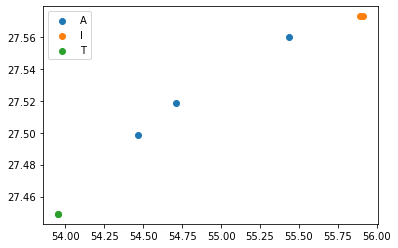

In [4]:
for tag in np.unique(example["assoc_tag"]):
    t_exam = example[example["assoc_tag"] == tag]
    plt.scatter(t_exam["ra"], t_exam["dec"], label=tag)

plt.legend()

In [6]:
len(orb[orb["chi_reduced"] != -1.0]), (len(orb[orb["chi_reduced"] != -1.0]) / len(orb))*100, len(orb[orb["chi_reduced"] == -1.0]), (len(orb[orb["chi_reduced"] == -1.0]) / len(orb))*100

(299, 55.78358208955224, 237, 44.21641791044777)

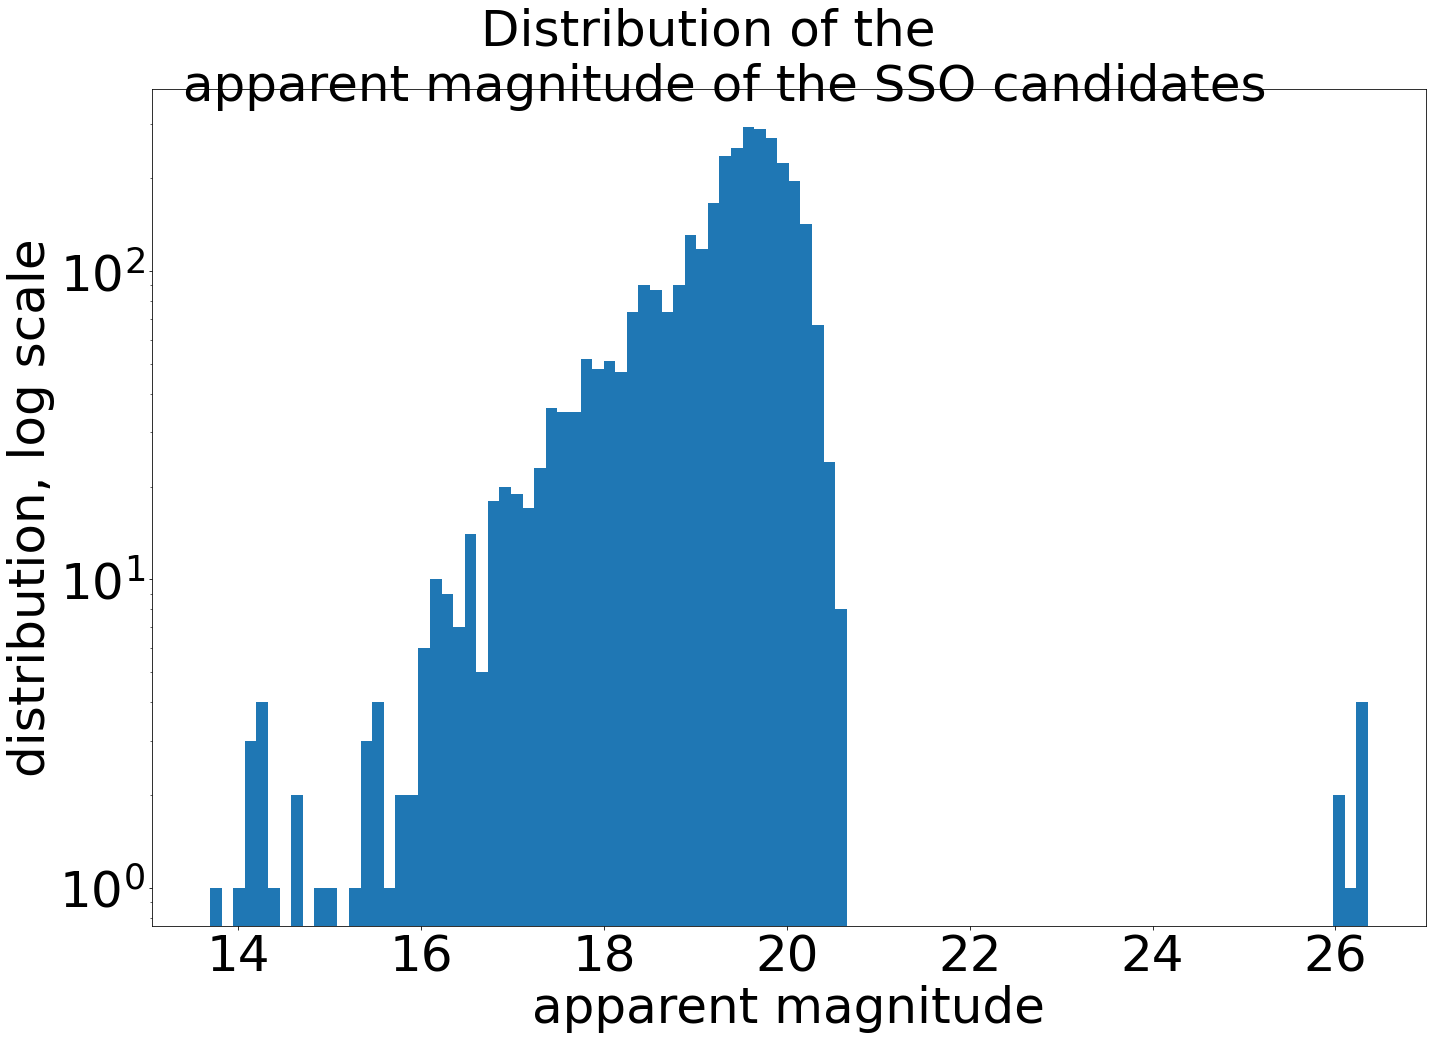

In [7]:
fig, ax = plt.subplots(figsize=(20, 15))

plt.hist(traj_orb["dcmag"], bins=100)

legend_size = 50

plt.xlabel("apparent magnitude", fontsize=legend_size)
plt.ylabel("distribution, log scale", fontsize=legend_size)
plt.suptitle("Distribution of the \n apparent magnitude of the SSO candidates", y=0.96, fontsize=legend_size)
plt.yscale("log")

ax.tick_params(axis='x', labelsize=legend_size)
ax.tick_params(axis='y', labelsize=legend_size)

plt.tight_layout()

plt.savefig("mag_distrib")

In [135]:
# load the mpc database
mpc_orb = pd.read_json("../mpcorb_extended.json")

In [4]:
len(mpc_orb)

1182775

In [10]:
mpc_close = mpc_orb[mpc_orb["a"] < 10]

In [11]:
orbit_type = np.unique(mpc_close["Orbit_type"])

In [14]:
traj_size = traj_orb[["trajectory_id", "ra"]].groupby(["trajectory_id"]).agg(
    traj_size=("ra", len)
)

traj_size
trajectory_id           
0                      6
1                      6
2                      6
3                      6
4                      7
...                  ...
46814                  6
47363                  6
47381                  6
47384                  6
47388                  6

[536 rows x 1 columns]

In [15]:
close_cand = orb[orb["a"] < 10]
close_cand = close_cand.merge(traj_size, on="trajectory_id")


/home/roman.le-montagner/Doctorat/Asteroids/Paper_experiments/fink_fat_env/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/roman.le-montagner/Doctorat/Asteroids/Paper_experiments/fink_fat_env/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


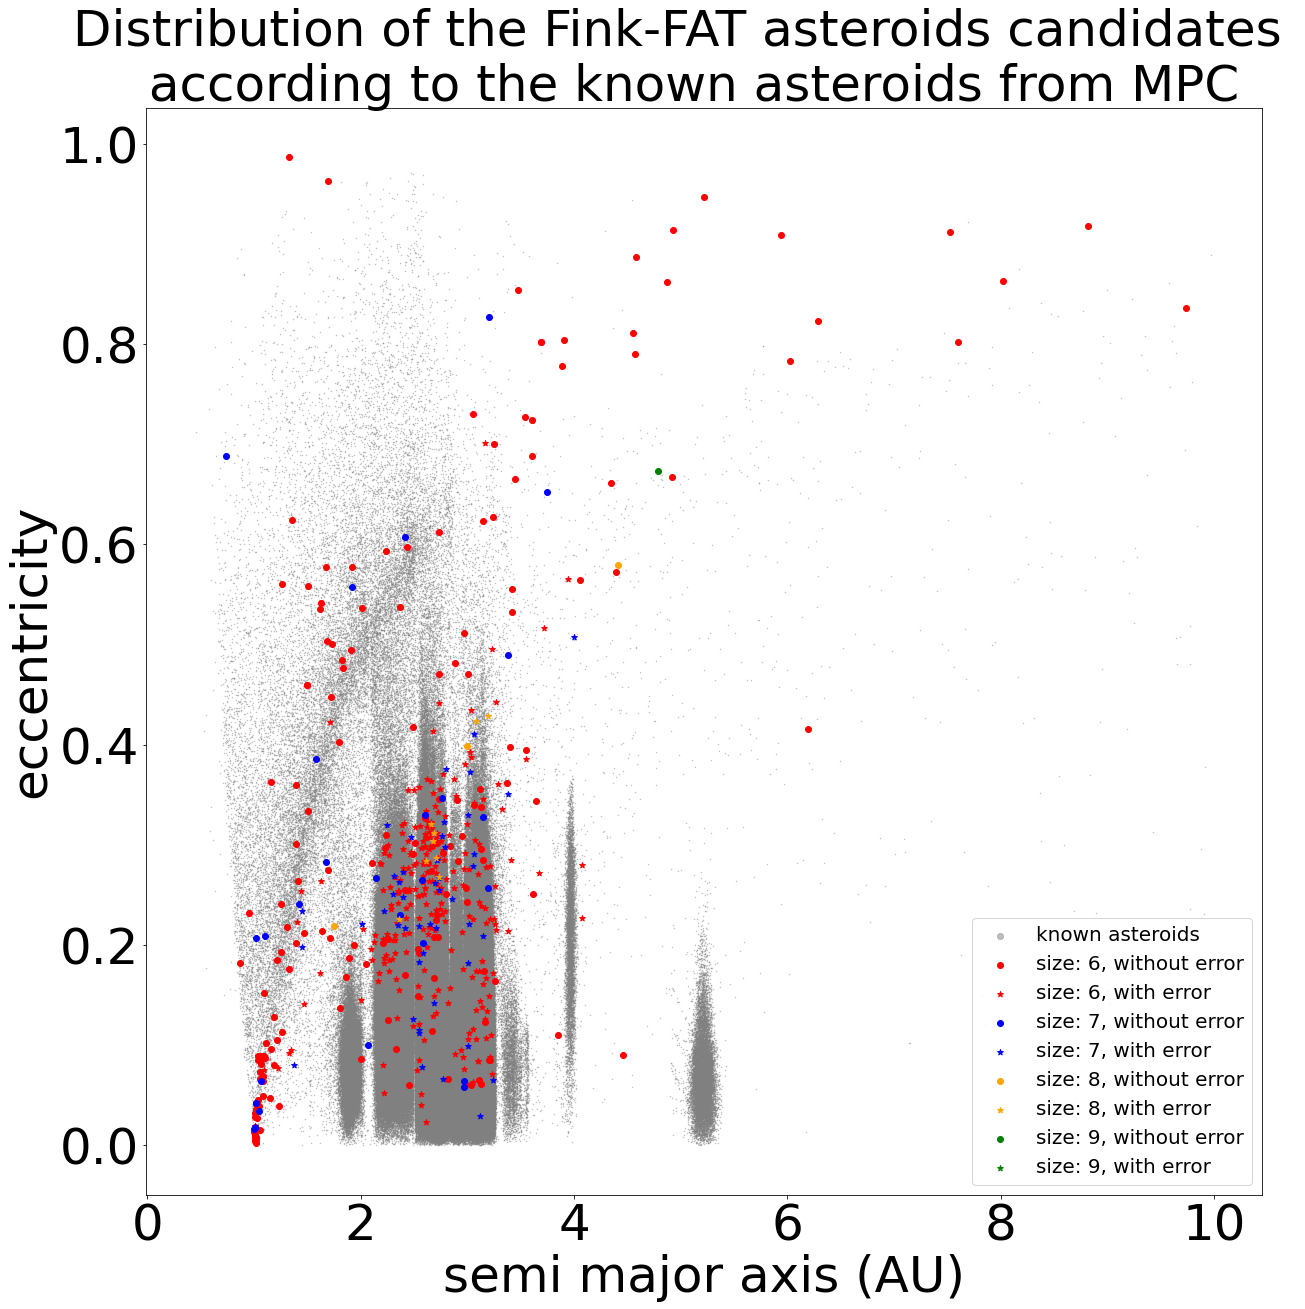

In [38]:
fig, ax = plt.subplots(figsize=(20, 20))

# for orb_t in orbit_type:
#     mpc_type = mpc_close[mpc_close["Orbit_type"] == orb_t]
#     plt.scatter(mpc_type["a"], mpc_type["e"], marker='.', s=1, label=orb_t)

cdict = {6: 'red', 7: 'blue', 8: 'orange', 9: 'green'}

plt.scatter(mpc_close["a"], mpc_close["e"], marker='.', s=1, label="known asteroids", color="grey", alpha=0.5)

for _size in np.unique(traj_size["traj_size"]):
    current_size = close_cand.where(close_cand["traj_size"] == _size)
    good_orb = current_size[current_size["chi_reduced"] != -1.0]
    bad_orb = current_size[current_size["chi_reduced"] == -1.0]

    plt.scatter(bad_orb["a"], bad_orb["e"], marker='o', label="size: {}, without error".format(_size), c=cdict[_size])
    plt.scatter(good_orb["a"], good_orb["e"], marker='*', label="size: {}, with error".format(_size), c=cdict[_size])


lgnd = plt.legend(prop={'size': 20})
lgnd.legendHandles[0]._sizes = [lgnd.legendHandles[2]._sizes * 4]

legend_size = 50

plt.xlabel("semi major axis (AU)", fontsize=legend_size)
plt.ylabel("eccentricity", fontsize=legend_size)
plt.suptitle("Distribution of the Fink-FAT asteroids candidates \n according to the known asteroids from MPC", fontsize=legend_size, y=0.95)

ax.tick_params(axis='x', labelsize=legend_size)
ax.tick_params(axis='y', labelsize=legend_size)

plt.savefig("fink_fat_candidates_distribution")

In [26]:
far_orb = orb[orb["a"] >= 10]
far_orb = far_orb.merge(traj_size, on="trajectory_id")
mpc_far = mpc_orb[(mpc_orb["a"] >= 10) & (mpc_orb["a"] <= 200)]

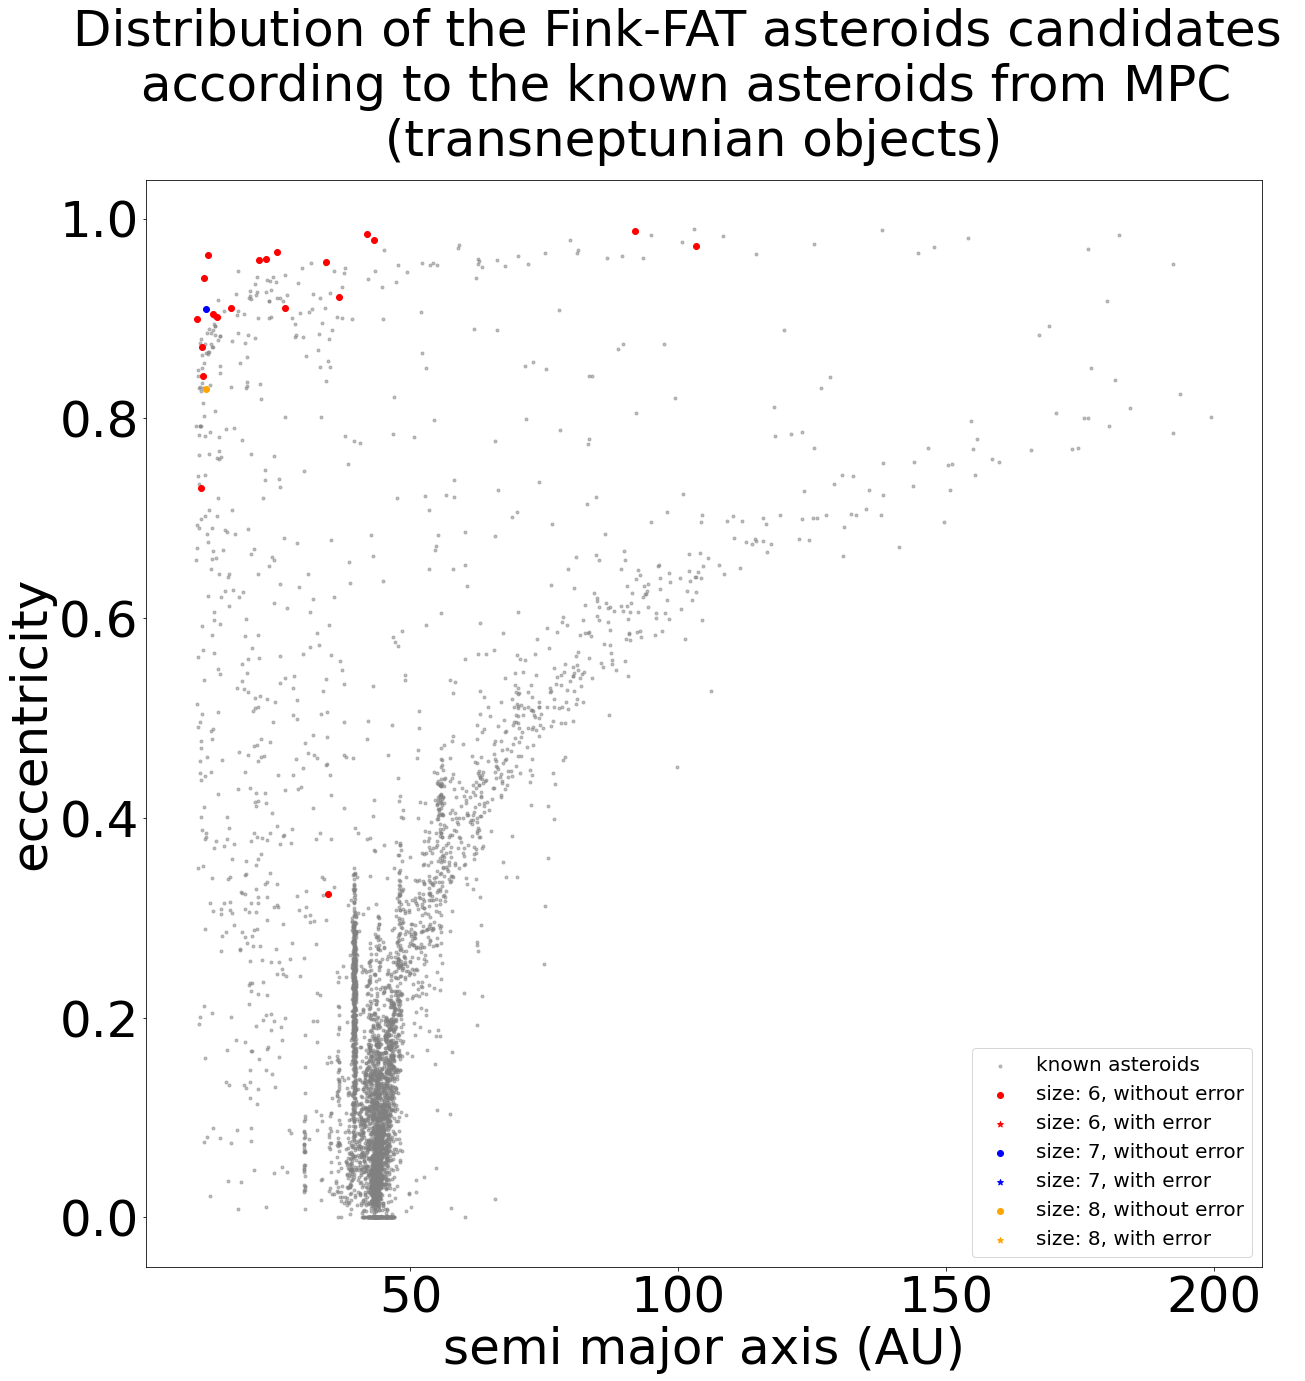

In [37]:
fig, ax = plt.subplots(figsize=(20, 20))

# for orb_t in orbit_type:
#     mpc_type = mpc_close[mpc_close["Orbit_type"] == orb_t]
#     plt.scatter(mpc_type["a"], mpc_type["e"], marker='.', s=1, label=orb_t)

plt.scatter(mpc_far["a"], mpc_far["e"], marker='.', label="known asteroids", color="grey", alpha=0.5)

for _size in np.unique(traj_size["traj_size"]):
    current_size = far_orb.where(far_orb["traj_size"] == _size)
    if current_size["traj_size"].isna().all():
        continue
    good_far_o = current_size[current_size["chi_reduced"] != -1.0]
    bad_far_o = current_size[current_size["chi_reduced"] == -1.0]
    plt.scatter(bad_far_o["a"], bad_far_o["e"], marker='o', label="size: {}, without error".format(_size), c=cdict[_size])
    plt.scatter(good_far_o["a"], good_far_o["e"], marker='*', label="size: {}, with error".format(_size), c=cdict[_size])


lgnd = plt.legend(prop={'size': 20})
lgnd.legendHandles[0]._sizes = [lgnd.legendHandles[2]._sizes]

legend_size = 50

plt.xlabel("semi major axis (AU)", fontsize=legend_size)
plt.ylabel("eccentricity", fontsize=legend_size)
plt.suptitle("Distribution of the Fink-FAT asteroids candidates \n according to the known asteroids from MPC \n (transneptunian objects)", fontsize=legend_size, y=1)

ax.tick_params(axis='x', labelsize=legend_size)
ax.tick_params(axis='y', labelsize=legend_size)

plt.savefig("fink_fat_candidates_distribution_far_objects")

In [41]:
mpc_with_orb = pd.read_parquet("../mpc_with_orb.parquet")
error_cand = orb[orb["chi_reduced"] != -1.0]
success_fit = mpc_with_orb[(mpc_with_orb["a"] != -1.0) & (mpc_with_orb["rms_a"] != -1.0)]

success_fit["type"] = "known SSO"
error_cand["type"] = "Fink-FAT candidates"
mpc_cand = pd.concat([success_fit, error_cand]).reset_index(drop=True)

/home/roman.le-montagner/Doctorat/Asteroids/Paper_experiments/fink_fat_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/roman.le-montagner/Doctorat/Asteroids/Paper_experiments/fink_fat_env/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


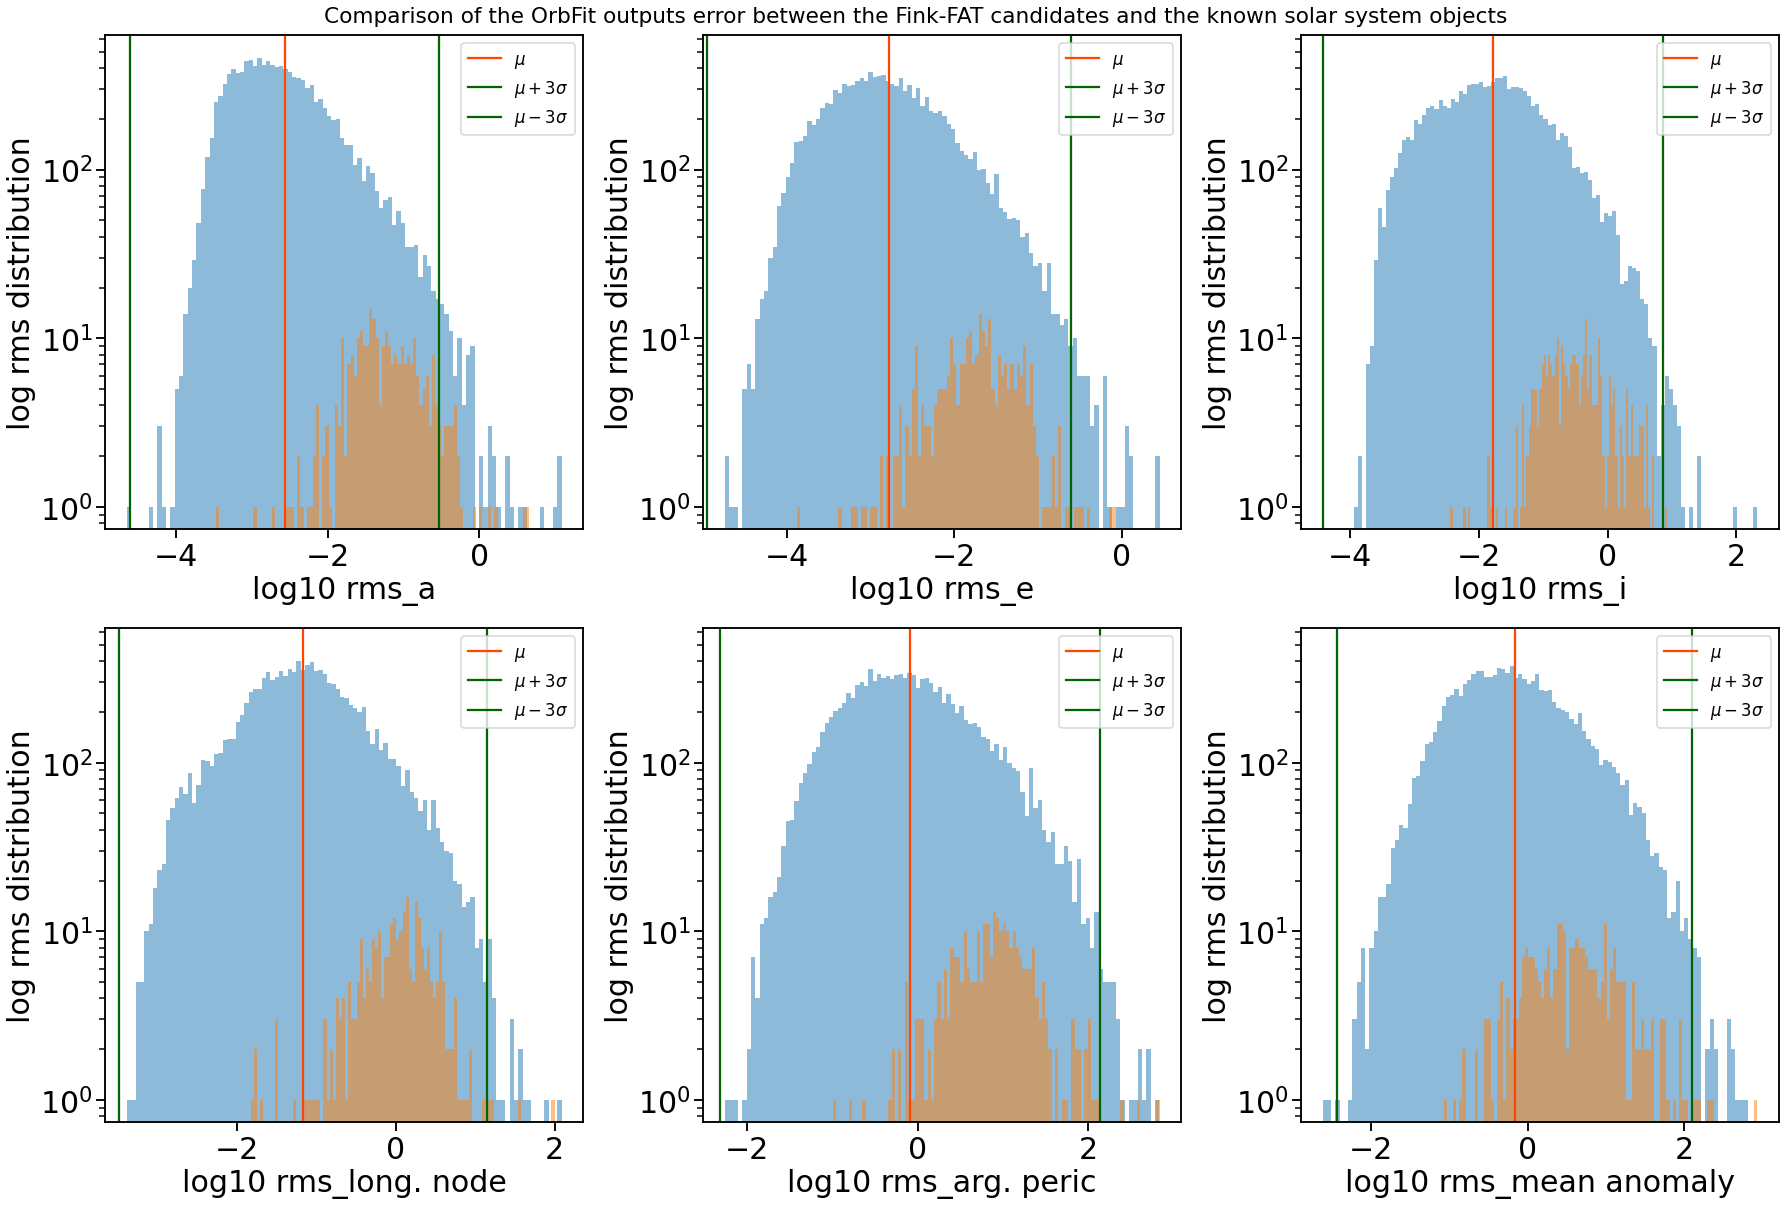

In [112]:
def plot_hist_rms(mpc_cand, ax, rms_params):
    mpc_rms_a = mpc_cand[mpc_cand["type"] == "known SSO"]
    cand_rms_a = mpc_cand[mpc_cand["type"] == "Fink-FAT candidates"]
    ax.hist(np.log10(mpc_rms_a[rms_params]), bins=100, alpha=0.5, log=True)
    ax.hist(np.log10(cand_rms_a[rms_params]), bins=100, alpha=0.5, log=True)

    mu_a = np.mean(np.log10(mpc_rms_a[rms_params]))
    sig_a = np.std(np.log10(mpc_rms_a[rms_params]))
    ax.axvline(mu_a, label=r"$\mu$", color="orangered")
    ax.axvline(mu_a + (3 * sig_a), label=r"$\mu + 3\sigma$", color="darkgreen")
    ax.axvline(mu_a - (3 * sig_a), label=r"$\mu - 3\sigma$", color="darkgreen")

    legend_size = 30
    ax.set_xlabel("log10 {}".format(rms_params), fontsize=legend_size)
    ax.set_ylabel("log rms distribution", fontsize=legend_size)

    ax.tick_params(axis='x', labelsize=legend_size)
    ax.tick_params(axis='y', labelsize=legend_size)
    ax.legend()

fig = plt.figure(figsize=(30, 20))
fig.subplots_adjust(hspace=0.2, wspace=0.25)

ax = fig.add_subplot(2, 3, 1)
plot_hist_rms(mpc_cand, ax, "rms_a")

ax = fig.add_subplot(2, 3, 2, sharey=ax)
plot_hist_rms(mpc_cand, ax, "rms_e")

ax = fig.add_subplot(2, 3, 3, sharey=ax)
plot_hist_rms(mpc_cand, ax, "rms_i")

ax = fig.add_subplot(2, 3, 4, sharey=ax)
plot_hist_rms(mpc_cand, ax, "rms_long. node")

ax = fig.add_subplot(2, 3, 5, sharey=ax)
plot_hist_rms(mpc_cand, ax, "rms_arg. peric")

ax = fig.add_subplot(2, 3, 6, sharey=ax)
plot_hist_rms(mpc_cand, ax, "rms_mean anomaly")

plt.suptitle("Comparison of the OrbFit outputs error between the Fink-FAT candidates and the known solar system objects", y=0.9)

plt.savefig("orbfit_error_mpc_cand")

# Cross-match with SkyBot

association of the candidates with asteroids from the IMCCE database

In [7]:
def call_skybot(ra, dec, jd):

    r = requests.post(
        'http://vo.imcce.fr/webservices/skybot/skybotconesearch_query.php',
        params={
            '-ep': jd,
            '-ra': ra,
            '-dec': dec,
            '-rs': '5',
            '-mime': 'votable',
            '-observer': 'I41'
        }
    )

    try:
        with BytesIO(r.content) as f:
            vo_imcc = parse_single_table(f)
        
        return vo_imcc.array["name"][0]
    except IndexError:
        return "no asteroids"


def to_skybot(traj_cand):
    traj = traj_cand.to_numpy()
    
    ra, dec, jd = traj[0], traj[1], traj[2]

    res_skybot = call_skybot(ra, dec, "{}".format(jd))
    
    return res_skybot

def search_asteroids(df):
    return df.apply(to_skybot, axis=1)

def analyze_asteroids(rows):

    count_assoc = Counter(rows["assoc_asteroids"])

    if len(count_assoc.keys()) > 1:
        return "bad assoc"
    elif "no asteroids" in count_assoc.keys():
        return "no assoc"
    else:
        return list(count_assoc.keys())[0]

In [8]:
# tr_cand = traj_orb.reset_index(drop=True)

# split_obs = np.array_split(tr_cand.index, 12)

# chunks = [tr_cand.iloc[chunk] for chunk in split_obs]

# with Pool(12) as p:
#     res_parallel = p.map(search_asteroids, chunks)

# tr_cand["assoc_asteroids"] = pd.concat(res_parallel)

# tr_cand.to_parquet("assoc_ast.parquet")

In [9]:
tr_cand = pd.read_parquet("assoc_ast.parquet")

gb_cand = tr_cand.groupby("trajectory_id").agg(list).reset_index()

print(len(gb_cand))

gb_cand["assoc_analyze"] = gb_cand.apply(analyze_asteroids, axis=1)

real_assoc = gb_cand[~gb_cand["assoc_analyze"].isin(["bad assoc", "no assoc"])]

580


In [11]:
len(real_assoc), len(gb_cand[gb_cand["assoc_analyze"] == "bad assoc"]), len(gb_cand[gb_cand["assoc_analyze"] == "no assoc"])

(205, 268, 107)

In [7]:
np.unique(gb_cand["assoc_analyze"])

array(['1991 BM2', '1991 OH1', '1991 VX5', '1992 AE1', '1993 TQ27',
       '1995 TO1', '1996 AS13', '1997 EF32', '1997 JA', '1998 KV12',
       '1998 MU', '1998 XF72', '1999 CC9', '1999 CO112', '1999 DH5',
       '1999 JP82', '1999 RO199', '1999 RS201', '1999 RT117', '1999 TF90',
       '1999 TH270', '1999 TL112', '1999 TP171', '1999 TQ157',
       '1999 UP24', '1999 UU38', '1999 XD125', '2000 AN165', '2000 AO52',
       '2000 AX124', '2000 CM80', '2000 LP10', '2000 OW38', '2000 PW12',
       '2000 RH97', '2000 RK54', '2000 SJ156', '2000 SR210', '2000 TL63',
       '2000 UY107', '2000 VV59', '2000 VX56', '2000 WE14', '2000 XC52',
       '2000 XN7', '2001 BH28', '2001 FY95', '2001 QX335', '2001 RC4',
       '2001 SE229', '2001 SJ94', '2001 SR110', '2001 TA195', '2001 TN64',
       '2001 UJ236', '2001 XF213', '2001 XT68', '2002 AO14', '2002 BR3',
       '2002 CO141', '2002 LQ11', '2002 QS84', '2002 TK106', '2002 TY383',
       '2002 WA33', '2003 FJ79', '2003 HS19', '2003 PS13', '2004 EN1

In [142]:
mpc_orb["Number"] = mpc_orb["Number"].astype("string").str[1:-1]

mpc_orb.merge(gb_cand, left_on="Name", right_on="assoc_analyze")

H     G  Num_obs   rms  U  Arc_years Perturbers Perturbers_2 Number  \
0    9.86  0.15   2605.0  0.49  0  1908-2022        M-v          3Ek          
1   10.97  0.15   3560.0  0.55  0  1936-2022        M-v          3Ek          
2   12.92  0.15   2295.0  0.62  0  1932-2022        M-v          3Ek          
3   11.84  0.15   3437.0  0.52  0  1933-2021        M-v          3Ek          
4   12.40  0.15   2498.0  0.60  0  1980-2021        M-v          3Ek          
5   12.84  0.15   2377.0  0.60  0  1950-2021        M-v          3Ek          
6   13.70  0.15   3069.0  0.61  0  1947-2022        M-v          3Ek          
7   13.00  0.15   2285.0  0.60  0  1981-2022        M-v          3Ek          
8   12.88  0.15   2138.0  0.64  0  1979-2021        M-v          3Ek          
9   13.26  0.15   1748.0  0.68  0  1951-2021        M-v          3Ek          
10  12.69  0.15   2493.0  0.59  0  1988-2022        M-v          3Ek          
11  13.51  0.15   2276.0  0.65  0  1990-2021        M-v          3Ek      7   
12  13.60  0.15   2443.0  0.62  0  1984-2021        M-v          3Ek      4   
13  14.65  0.15   2023.0  0.69  0  1991-2021        M-v          3Ek      0   

         Name  ...                                   nid                 fid  \
0    Catriona  ...  [1699, 1699, 1701, 1705, 1707, 1707]  [2, 1, 1, 2, 1, 2]   
1     Masaryk  ...  [1680, 1682, 1685, 1688, 1690, 1694]  [2, 1, 2, 1, 1, 2]   
2   Scheffler  ...  [1688, 1688, 1694, 1694, 1698, 1700]  [1, 2, 2, 1, 1, 2]   
3     Belnika  ...  [1696, 1696, 1696, 1700, 1700, 1702]  [1, 1, 2, 2, 2, 2]   
4       Lapko  ...  [1694, 1695, 1696, 1698, 1700, 1705]  [1, 1, 1, 1, 2, 1]   
5     Leibniz  ...  [1695, 1695, 1699, 1701, 1701, 1701]  [1, 2, 2, 2, 1, 2]   
6     Tantawi  ...  [1700, 1700, 1704, 1706, 1707, 1707]  [2, 1, 2, 2, 1, 2]   
7   Sashakrot  ...  [1699, 1699, 1697, 1701, 1701, 1705]  [2, 1, 2, 2, 2, 1]   
8    Krikalev  ...  [1699, 1701, 1705, 1707, 1709, 1709]  [2, 1, 2, 1, 1, 2]   
9       Mckim  ...  [1684, 1686, 1686, 1689, 1697, 1701]  [2, 1, 2, 1, 2, 2]   
10   Samsagan  ...  [1688, 1688, 1690, 1690, 1694, 1701]  [1, 2, 2, 2, 1, 1]   
11   von Laue  ...  [1697, 1697, 1699, 1701, 1705, 1709]  [1, 2, 2, 1, 1, 1]   
12     Barlow  ...  [1701, 1701, 1699, 1702, 1705, 1705]  [1, 2, 1, 2, 2, 1]   
13  Camenzind  ...  [1045, 1045, 1045, 1045, 1046, 1046]  [2, 2, 2, 2, 2, 2]   

                                                dcmag  \
0   [14.041888517547116, 14.579348410923286, 14.38...   
1   [16.28707640938041, 16.74066115998356, 16.2811...   
2   [18.014936690713075, 17.606814570893405, 17.39...   
3   [16.594766754389745, 16.567724437406465, 16.00...   
4   [17.851254614134824, 17.619753651267054, 17.73...   
5   [18.244491583931477, 18.05172038424008, 18.068...   
6   [16.94802621467101, 17.505792312123226, 16.801...   
7   [16.849372157666586, 17.549230951013964, 16.75...   
8   [17.51942773200204, 17.843433201897412, 17.236...   
9   [18.242411571014557, 18.84331931919989, 18.441...   
10  [17.886991139922472, 17.352716005011672, 17.50...   
11  [18.117153088327658, 17.51981942153112, 17.574...   
12  [18.29174899639407, 17.542006284340417, 18.209...   
13  [18.538728217944495, 18.60788813460968, 18.673...   

                                               candid  \
0   [1699312953915015002, 1699356673915015002, 170...   
1   [1680374614915015001, 1682420184915015004, 168...   
2   [1688333484115015003, 1688336354115015005, 169...   
3   [1696253200215015006, 1696252736015015000, 169...   
4   [1694314620315015000, 1695251531415015000, 169...   
5   [1695230752815015004, 1695315272815015004, 169...   
6   [1700338964415015031, 1700365274415015022, 170...   
7   [1699316291315015001, 1699381651315015008, 169...   
8   [1699294132415015007, 1701315122415015002, 170...   
9   [1684317024015015003, 1686272164015015019, 168...   
10  [1688296755215015002, 1688352785215015001, 169...   
11  [1697230863615015001, 1697301093615015021, 169...   
12  [1701231211415015022

In [143]:
mpc_orb.merge(gb_cand, left_on="Number", right_on="assoc_analyze")

Empty DataFrame
Columns: [H, G, Num_obs, rms, U, Arc_years, Perturbers, Perturbers_2, Number, Name, Principal_desig, Other_desigs, Epoch, M, Peri, Node, i, e, n, a, Ref, Num_opps, Computer, Hex_flags, Last_obs, Tp, Orbital_period, Perihelion_dist, Aphelion_dist, Semilatus_rectum, Synodic_period, Orbit_type, NEO_flag, One_km_NEO_flag, PHA_flag, Critical_list_numbered_object_flag, One_opposition_object_flag, Arc_length, trajectory_id, ra, dec, jd, nid, fid, dcmag, candid, not_updated, ssnamenr, dcmag_err, assoc_tag, assoc_asteroids, assoc_analyze]
Index: []

[0 rows x 52 columns]

In [153]:
r = requests.post(
        'https://ssp.imcce.fr/webservices/ssodnet/api/resolver.php',
        json={
            '-name': '1995 TO1',
            '-mime': 'json'
        }
    )

pd.read_json(r.content)

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│                                                                                           │
│ /tmp/ipykernel_31946/3056728888.py:9 in <cell line: 9>                                    │
│                                                                                           │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_31946/3056728888.py'                 │
│ /home/roman.le-montagner/.conda/envs/fink_fat_env/lib/python3.9/site-packages/pandas/util │
│ /_decorators.py:207 in wrapper                                                            │
│                                                                                           │
│   204 │   │   │   │   │   raise TypeError(msg)                                            │
│   205 │   │   │   │   else:                                                               │
│   206 │   │   │   │   │   kwargs[new_arg_name] = new_arg_value                            │
│ ❱ 207 │   │   │   return func(*args, **kwargs)                                            │
│   208 │   │                                                                               │
│   209 │   │   return cast(F, wrapper)                                                     │
│   210                                                                                     │
│                                                                                           │
│ /home/roman.le-montagner/.conda/envs/fink_fat_env/lib/python3.9/site-packages/pandas/util │
│ /_decorators.py:311 in wrapper                                                            │
│                                                                                           │
│   308 │   │   │   │   │   FutureWarning,                                                  │
│   309 │   │   │   │   │   stacklevel=stacklevel,                                          │
│   310 │   │   │   │   )                                                                   │
│ ❱ 311 │   │   │   return func(*args, **kwargs)                                            │
│   312 │   │                                                                               │
│   313 │   │   return wrapper                                                              │
│   314                                                                                     │
│                                                                                           │
│ /home/roman.le-montagner/.conda/envs/fink_fat_env/lib/python3.9/site-packages/pandas/io/j │
│ son/_json.py:588 in read_json                                                             │
│                                                                                           │
│    585 │   if convert_axes is None and orient != "table":                                 │
│    586 │   │   convert_axes = True                                                        │
│    587 │                                                                                  │
│ ❱  588 │   json_reader = JsonReader(                                                      │
│    589 │   │   path_or_buf,                                                               │
│    590 │   │   orient=orient,                                                             │
│    591 │   │   typ=typ,                                                                   │
│                                                                                           │
│ /home/roman.le-montagner/.conda/envs/fink_fat_env/lib/python3.9/site-packages/pandas/io/j │
│ son/_json.py:673 in __init__                                                              │
│                                                                                           │
│    670 │   │   │   if not self.lines:                                                     │
│    671 │   │   │   │   raise ValueError("nrows can

In [9]:
asteroid_db = np.unique(real_assoc["assoc_analyze"])

rocks_db = rocks.rocks(asteroid_db, progress=True)

orb_rocks = pd.DataFrame([[
    r.name, 
    r.a.value, 
    r.e.value, 
    r.i.value, 
    r.parameters.dynamical.orbital_elements.node_longitude.value,
    r.parameters.dynamical.orbital_elements.perihelion_argument.value,
    r.parameters.dynamical.orbital_elements.mean_anomaly.value] for r in rocks_db], columns=["Name", "a", "e", "i", "long. node", "arg. peric", "mean anomaly"])

Getting ssoCards ━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  19% 0:00:46

In [43]:
cand_asteroids = real_assoc[["trajectory_id", "assoc_analyze"]].merge(orb_rocks, left_on="assoc_analyze", right_on="Name")
print(len(cand_asteroids))
orbit_cand_known = cand_asteroids.merge(orb, on="trajectory_id", suffixes=("_known", "_cand"))

computed_elem = orbit_cand_known[
    ["a_known", "e_known", "i_known", "long. node_known", "arg. peric_known", "mean anomaly_known"]
]
known_elem = orbit_cand_known[["a_cand", "e_cand", "i_cand", "long. node_cand", "arg. peric_cand", "mean anomaly_cand"]]

orbit_cand_known[["da", "de", "di", "dNode", "dPeri", "dM"]] = (
    np.abs(computed_elem.values - known_elem.values)
) / computed_elem.values

203


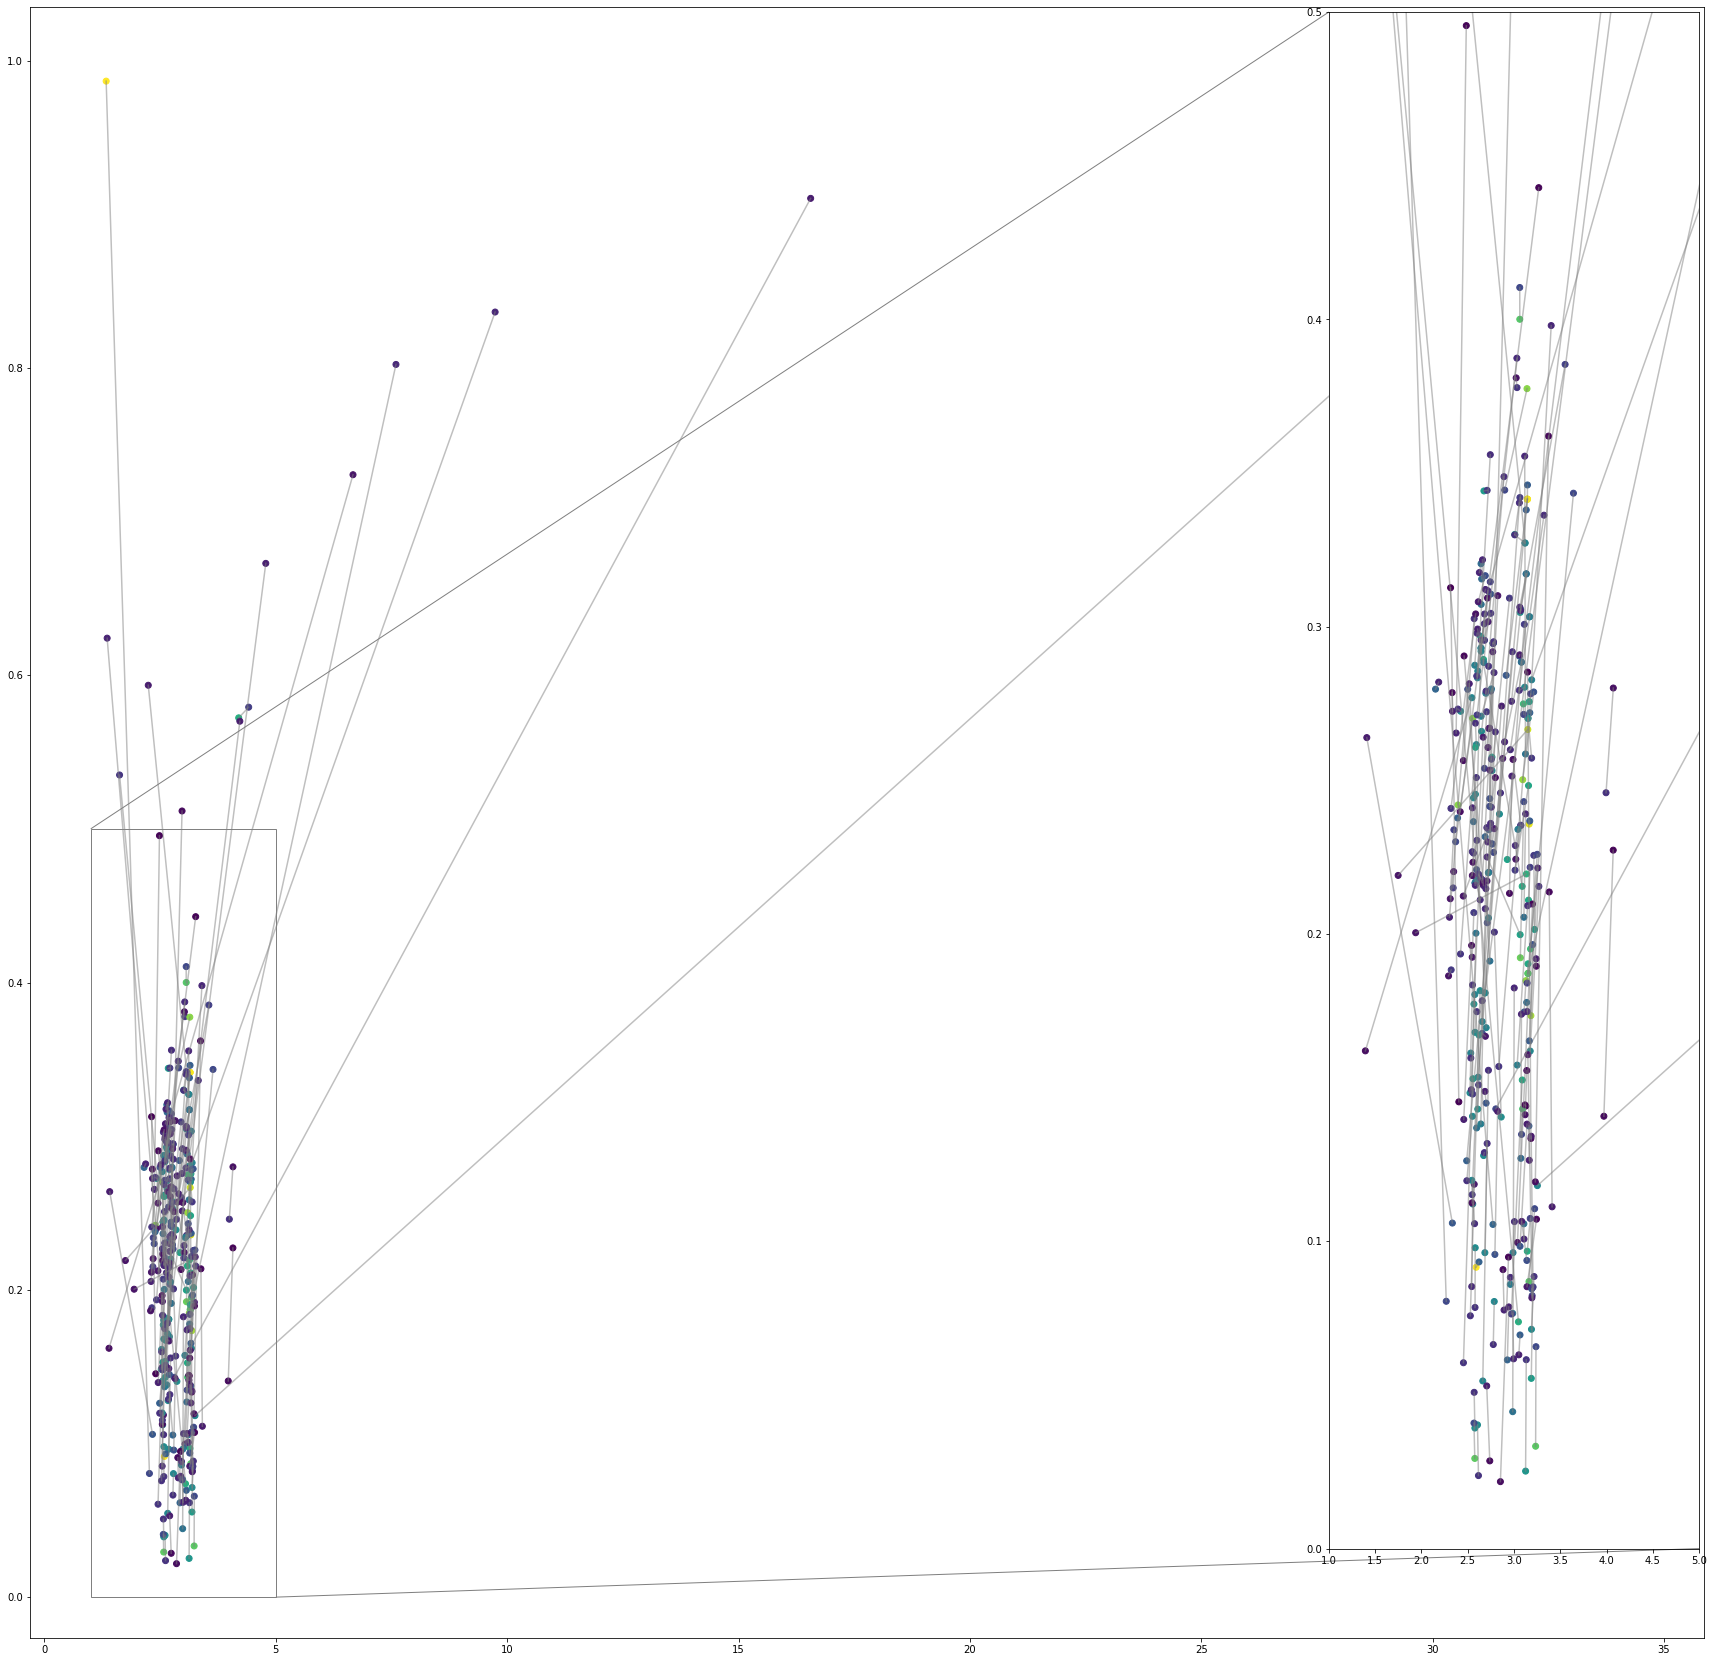

In [18]:
coord_1 = np.array([orbit_cand_known["a_known"], orbit_cand_known["a_cand"]])
coord_2 = np.array([orbit_cand_known["e_known"], orbit_cand_known["e_cand"]])

fig, ax = plt.subplots(figsize=(30, 30))

ax.plot(coord_1, coord_2, color="grey", alpha=0.5)
ax.scatter(orbit_cand_known["a_known"], orbit_cand_known["e_known"], c=orbit_cand_known["i_known"])
ax.scatter(orbit_cand_known["a_cand"], orbit_cand_known["e_cand"], c=orbit_cand_known["i_cand"])


from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

axins = zoomed_inset_axes(ax, 2, loc=1)
axins.plot(coord_1, coord_2, color="grey", alpha=0.5)
axins.scatter(orbit_cand_known["a_known"], orbit_cand_known["e_known"], c=orbit_cand_known["i_known"])
axins.scatter(orbit_cand_known["a_cand"], orbit_cand_known["e_cand"], c=orbit_cand_known["i_cand"])

x1, x2, y1, y2 = 1, 5, 0, 0.5
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

plt.show()

107


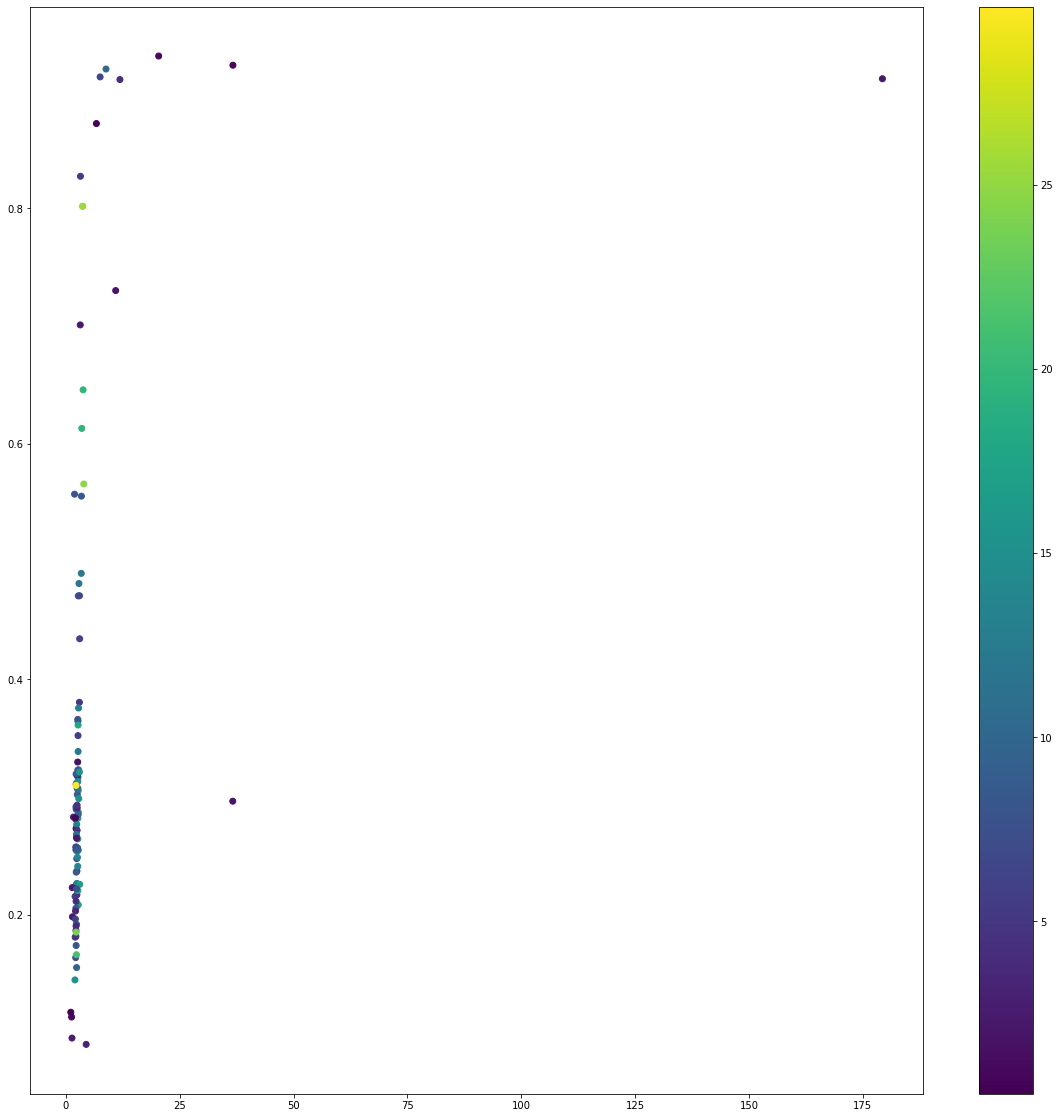

In [9]:
new_asteroids = gb_cand[gb_cand["assoc_analyze"] == "no assoc"]
print(len(new_asteroids))
new_orb = new_asteroids.merge(orb, on="trajectory_id")

fig = plt.figure(figsize=(20, 20))
sc = plt.scatter(new_orb["a"], new_orb["e"], c=new_orb["i"])
plt.colorbar(sc)
plt.show()

# Ephemeris fitting

In [26]:
def write_target_json(orb_list):

    dict_param = dict()
    dict_param["type"] = "Asteroid"
    dynamical_parameters = dict()
    
    dynamical_parameters["ref_epoch"] = orb_list[0]
    dynamical_parameters["semi_major_axis"] = orb_list[1]
    dynamical_parameters["eccentricity"] = orb_list[2]
    dynamical_parameters["inclination"] = orb_list[3]

    # dynamical_parameters["node_longitude"] = rows["Node"]
    # dynamical_parameters["perihelion_argument"] = rows["Peri"]
    # dynamical_parameters["mean_anomaly"] = rows["M"]

    dynamical_parameters["node_longitude"] = orb_list[4]
    dynamical_parameters["perihelion_argument"] = orb_list[5]
    dynamical_parameters["mean_anomaly"] = orb_list[6]

    dict_param["dynamical_parameters"] = dynamical_parameters

    with open(
        os.path.join("@aster_{}.json".format(int(orb_list[7]))), "w"
    ) as outfile:
        json.dump(dict_param, outfile, indent=4)

In [148]:
def write_target(orb_df):
    orb_select = orb_df[["ref_epoch", "a", "e", "i", "long. node", "arg. peric", "mean anomaly", "trajectory_id"]].values
    
    for orb_elem in orb_select:
        write_target_json(orb_elem)

def request_ephem(path_target, ephem_date):
    url = "https://ssp.imcce.fr/webservices/miriade/api/ephemcc.php"
    #url = "https://ssp.imcce.fr/webservices/miriade/miriade.php"
    
    trajectory_id = int(path_target.split(".")[0].split("_")[1])
    
    params = {
        "-name": "",
        "-type": "Asteroid",
        "-tscale": "UTC",
        "-observer": "I41",
        "-theory": "INPOP",
        "-teph": 1,
        "-tcoor": 5,
        "-oscelem": "MPCORB",
        "-mime": "json",
        "-output": "--jd",
        "-from": "MiriadeDoc",
    }
    
    files = {
        "target": open(path_target, "rb").read(),
        "epochs": ("epochs", "\n".join(["%.6f" % epoch for epoch in ephem_date])),
    }

    r = requests.post(url, params=params, files=files, timeout=2000)
    j = r.json()
    ephem = pd.DataFrame.from_dict(j["data"])

    coord = SkyCoord(ephem["RA"], ephem["DEC"], unit=(u.deg, u.deg))

    ephem["cRA"] = coord.ra.value * 15
    ephem["cDec"] = coord.dec.value
    ephem["trajectory_id"] = trajectory_id
    
    return ephem

In [149]:
def generate_ephemeris(orb_df, date_ephem):
    write_target(orb_df)

    all_target_path = sorted(glob.glob(os.path.join("@aster_*.json")))
    
    all_ephem = [request_ephem(path, date) for path, date in zip(all_target_path, date_ephem)]
    
    for path in all_target_path:
        os.remove(path)
    
    return pd.concat(all_ephem)

In [50]:
def error_ephem(df_ephem):
    # fmt: off
    deltaRAcosDEC = (df_ephem["ra"] - df_ephem["cRA"]) * np.cos(np.radians(df_ephem["dec"].astype(np.float64))) * 3600
    # fmt: on

    deltaDEC = (df_ephem["dec"] - df_ephem["cDec"]) * 3600
    
    return deltaRAcosDEC, deltaDEC

def ephem_fit(traj_data, traj_id, num_p = 100):
    example = traj_data[traj_data["trajectory_id"] == traj_id]
    date_ephem = example["jd"].to_numpy()
    linear_date = np.linspace(date_ephem[0], date_ephem[-1], num=num_p)

    ii = np.searchsorted(linear_date, date_ephem)
    linear_date = np.insert(linear_date, ii, date_ephem)

    ephem = generate_ephemeris(example, [linear_date])

    ephem_and_obs = example.round(6).merge(ephem, left_on="jd", right_on="Date")
    
    deltaRAcosDEC, deltaDEC = error_ephem(ephem_and_obs)

    error_coord = np.vstack((deltaRAcosDEC, deltaDEC)).T
    zero_base = np.zeros((1, 2))
    
    ephem["mean_sep_error"] = np.mean(distance.cdist(error_coord, zero_base))
    
    return ephem

def compute_ephem(data):
    return pd.concat([ephem_fit(data, id, 10) for id in np.unique(data["trajectory_id"])])

In [202]:
orb_traj = traj_orb.merge(orb, on="trajectory_id")
# split_tr_id = np.array_split(np.unique(orb_traj["trajectory_id"]), 12)

# chunks = [orb_traj[orb_traj["trajectory_id"].isin(chunk)] for chunk in split_tr_id]

# with Pool(12) as p:
#     res_parallel = p.map(compute_ephem, chunks)

# res_ephem = pd.concat(res_parallel)
res_ephem = compute_ephem(orb_traj)

In [204]:
res_ephem.sort_values("mean_sep_error")

Date         LAST              RA            DEC         HA  \
13  2.459415e+06  03:18:32.01  +23:35:36.7163  -03:52:20.378   3.715360   
9   2.459412e+06  13:45:02.95  +23:35:45.4725  -03:51:13.706  14.154854   
10  2.459412e+06  21:27:08.72  +23:35:44.7430  -03:51:19.377  21.856661   
11  2.459412e+06  22:52:52.77  +23:35:44.6007  -03:51:20.434  23.285602   
12  2.459413e+06  08:31:47.48  +23:35:41.2566  -03:51:45.953   8.935061   
..           ...          ...             ...            ...        ...   
12  2.459455e+06  09:23:24.96  +23:21:04.8117  -09:05:09.338  10.038931   
13  2.459457e+06  04:10:58.71  +23:19:31.4192  -09:17:55.757   4.857581   
14  2.459459e+06  22:58:32.46  +23:19:26.2555  -09:28:42.210  23.651724   
5   2.459446e+06  11:25:36.27  +23:27:49.4180  -07:37:29.473  11.963016   
8   2.459452e+06  19:48:17.50  +23:24:51.5366  -08:46:44.747  20.390544   

            Az          H       Dobs     Dhelio       VMag      Phase  \
13  246.103083  25.601893  29.315301  29.895438  14.960114   1.614737   
9    52.627631 -47.833225  29.375721  29.905422  14.971258   1.676981   
10  134.439652  41.959469  29.370147  29.904523  14.970273   1.671635   
11  162.688469  51.431146  29.369120  29.904356  14.970088   1.670616   
12  294.372351 -38.040177  29.345284  29.900428  14.965751   1.646589   
..         ...        ...        ...        ...        ...        ...   
12  305.116301 -53.636849   0.007291   1.017076  -9.737413  12.818272   
13  252.637919   8.860125   0.007848   1.017315  -9.668500  10.849959   
14  172.450519  46.876655   0.008389   1.017510  -9.598601   9.321346   
5   358.733691 -64.262395   0.003222   1.014816 -11.100761  23.026099   
8   119.099346  23.554616   0.005895   1.016437 -10.018993  17.037412   

        Elong.          AM  dRAcosDEC      dDEC         RV         cRA  \
13  124.002217    2.303640  -0.028152 -0.013798 -28.592771  353.902985   
9   120.566797 -999.000000  -0.022582 -0.012208 -30.080565  353.939469   
10  120.878378    1.493681  -0.024803 -0.012363 -29.999802  353.936429   
11  120.936235    1.278133  -0.025022 -0.012367 -29.850211  353.935836   
12  122.283343 -999.000000  -0.024780 -0.012971 -29.124263  353.921902   
..         ...         ...        ...       ...        ...         ...   
12  167.089966 -999.000000   3.477935  0.099854   0.792738  350.270049   
13  169.066204    6.247604  -1.600787  0.405244   0.931495  349.880913   
14  170.601516    1.368798  -4.243719 -0.263897   0.500484  349.859398   
5   156.902543 -999.000000   9.205032 -0.896985   1.144811  351.955908   
8   162.864686    2.488632  -3.586090 -0.967399   0.405188  351.214736   

        cDec  trajectory_id  mean_sep_error  
13 -3.872327           7686        2.174236  
9  -3.853807           7686        2.174236  
10 -3.855383           7686        2.174236  
11 -3.855676           7686        2.174236  
12 -3.862765           7686        2.174236  
..       ...            ...             ...  
12 -9.085927          14806    27859.584687  
13 -9.298821          14806    27859.584687  
14 -9.478392          14806    27859.584687  
5  -7.624854          14806    27859.584687  
8  -8.779096          14806    27859.584687  

[9374 rows x 20 columns]

In [211]:
res_ephem.to_parquet("ephem_data.parquet")

# Study of the trajectories scoring

In [254]:
def plot_ephem(real_obs, ephem_obs):


    ephem_and_obs = real_obs.round(6).merge(ephem_obs, left_on="jd", right_on="Date")

    deltaRAcosDEC, deltaDEC = error_ephem(ephem_and_obs)


    colors = ["#15284F", "#F5622E"]

    fig, ax = plt.subplots(figsize=(10, 10), sharex=True,)

    # fig.suptitle(
    #     "Trajectories / ephemeris : {} trajectories of {} points".format(
    #         n_trajectories, n_points
    #     )
    # )

    ax.plot(
        ephem_obs["cRA"],
        ephem_obs["cDec"],
        ls="",
        color="black",
        marker=".",
        alpha=0.2,
        label="Ephemerides",
    )

    for night in np.unique(real_obs["nid"]):
        current_night = real_obs[real_obs["nid"] == night]
        ax.scatter(
            current_night["ra"],
            current_night["dec"],
            label=night,
            alpha=0.5,
            s=100
        )

    ax.legend(loc="best")
    ax.set_xlabel("RA ($^o$)")
    ax.set_ylabel("DEC ($^o$)")

    axins = ax.inset_axes([1.1, 0.1, 0.40, 0.40])

    axins.plot(deltaRAcosDEC, deltaDEC, ls="", color=colors[0], marker="x", alpha=0.5)
    axins.errorbar(
        np.mean(deltaRAcosDEC),
        np.mean(deltaDEC),
        xerr=np.std(deltaRAcosDEC),
        yerr=np.std(deltaDEC),
    )
    axins.axhline(0, ls="--", color="black")
    axins.axvline(0, ls="--", color="black")
    axins.set_xlabel(r"$\Delta$RA ($^{\prime\prime}$)")
    axins.set_ylabel(r"$\Delta$DEC ($^{\prime\prime}$)")

    plt.show()

### Plot best orbit based on quadratic score

In [260]:
new_cand_with_ephem = new_asteroids.merge(res_ephem, on="trajectory_id")
new_cand_with_orb = new_asteroids.merge(orb, on="trajectory_id")

In [269]:
def quadratic_score(df):
    df["rms_dist"] = np.linalg.norm(
        df[
            [
                "rms_a",
                "rms_e",
                "rms_i",
                "rms_long. node",
                "rms_arg. peric",
                "rms_mean anomaly",
            ]
        ].values
        # mean of the error distribution computed over all the known MPC with exactly 6 points in Fink
        - [0.018712, 0.009554, 0.170369, 0.383595, 4.314636, 3.791175],
        axis=1,
    )

    df["chi_dist"] = np.abs(df["chi_reduced"].values - 1)

    df["score"] = np.linalg.norm(
        df[["rms_dist", "chi_dist"]].values - [0, 0], axis=1
    )

    return df

new_cand_quad_score = quadratic_score(new_cand_with_orb)
cand_quad_error = new_cand_quad_score.sort_values("score")[["trajectory_id", "score"]]
quad_score = cand_quad_error.groupby("trajectory_id").agg(lambda x: list(x)[0]).sort_values("score").reset_index()

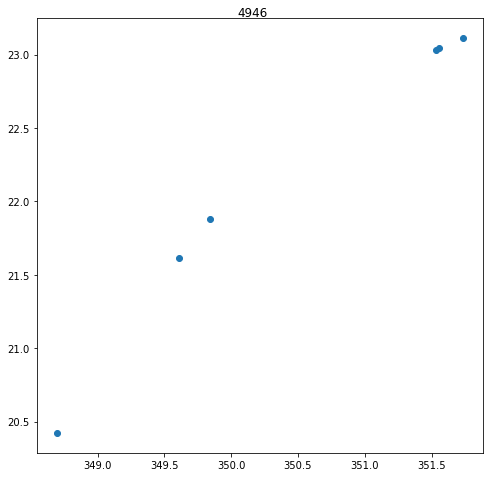

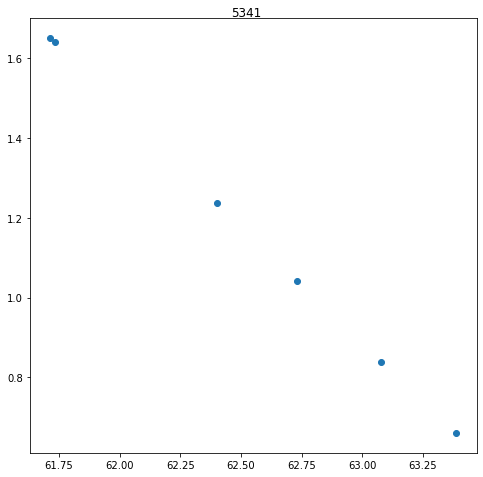

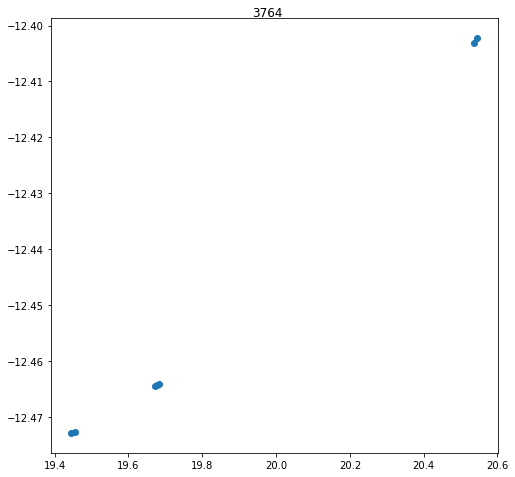

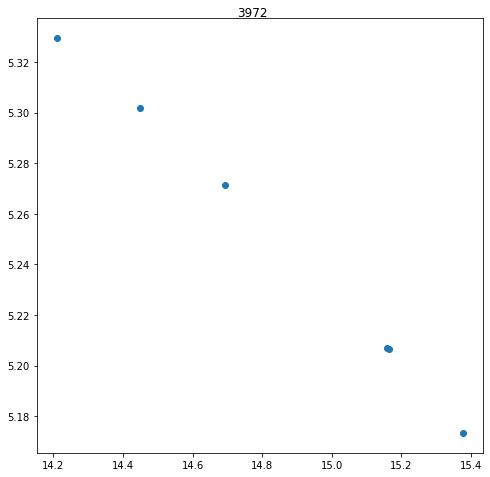

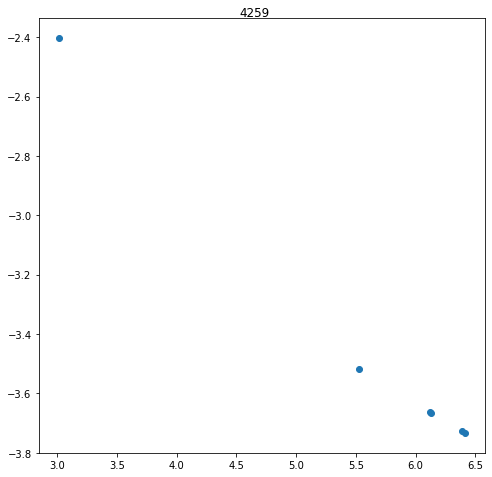

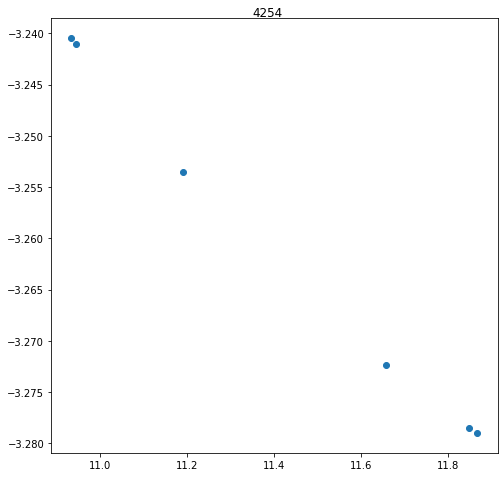

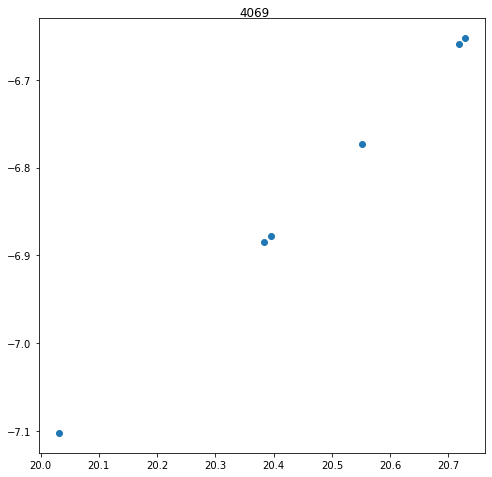

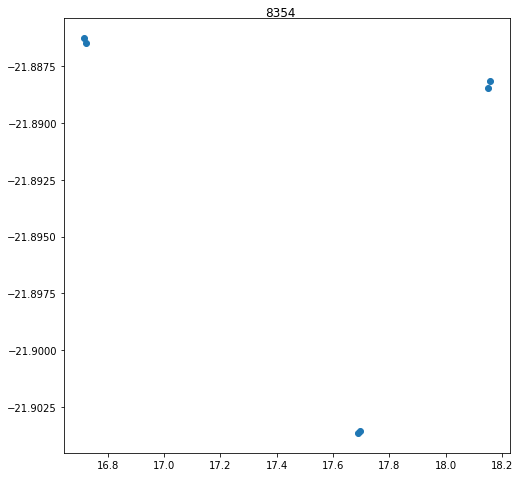

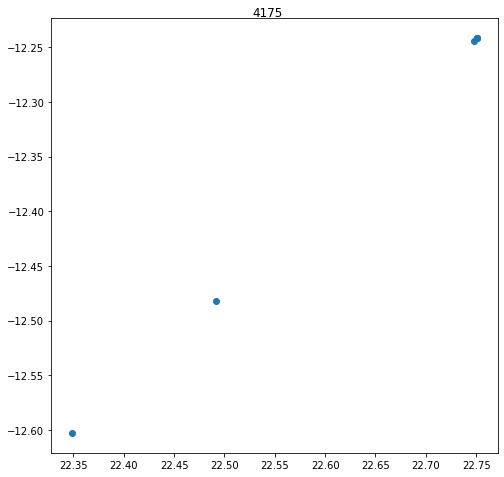

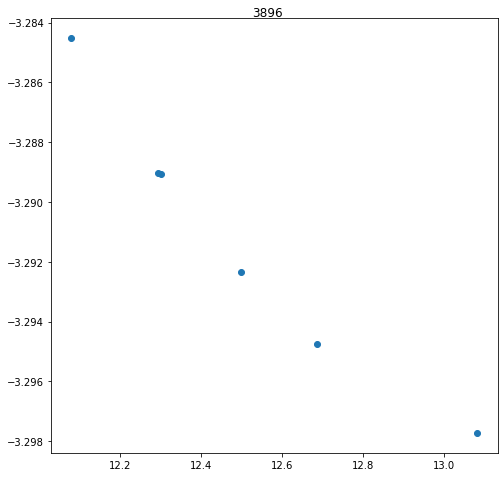

In [277]:
for tr_id in quad_score["trajectory_id"].iloc[-10:]:
    current_tr = tr_cand[tr_cand["trajectory_id"] == tr_id]

    fig = plt.figure(figsize=(8, 8))
    plt.scatter(current_tr["ra"], current_tr["dec"])
    fig.suptitle(tr_id, y=0.9)
    plt.show()

### Plot new candidates ephemeris

In [298]:
ephem_error = new_cand_with_ephem.sort_values("mean_sep_error")[["trajectory_id", "mean_sep_error"]]
ephem_score = ephem_error.groupby("trajectory_id").agg(lambda x: list(x)[0]).sort_values("mean_sep_error").reset_index()

### Plot best orbits based on ephemeris score

In [302]:
ephem_score.iloc[:10]

trajectory_id  mean_sep_error
0           7686        2.174236
1           2789        3.916295
2           7462        5.091264
3           7720       19.803366
4           7777       21.104383
5           2916       21.119658
6           4064       21.981747
7           7626       22.940994
8           3763       23.169420
9           7924       23.748725

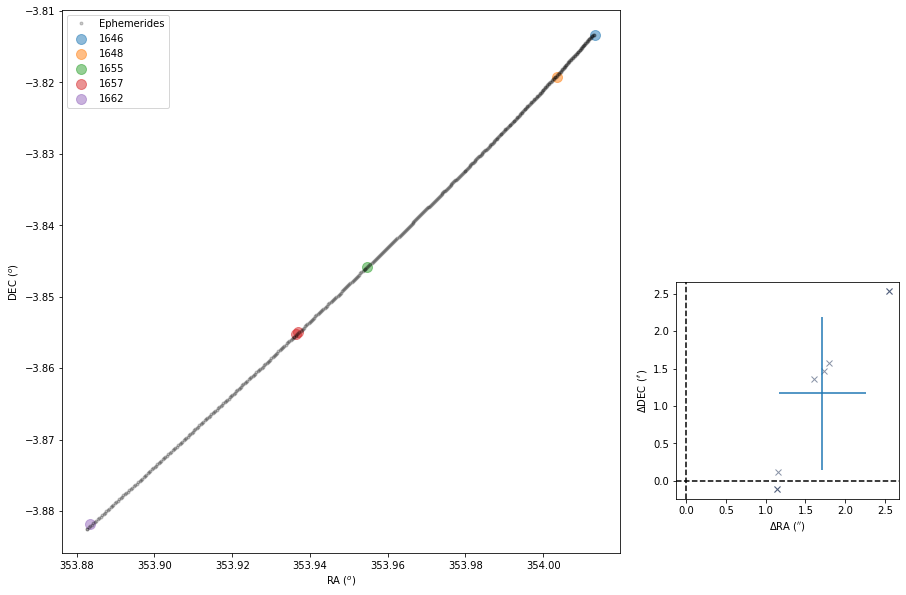

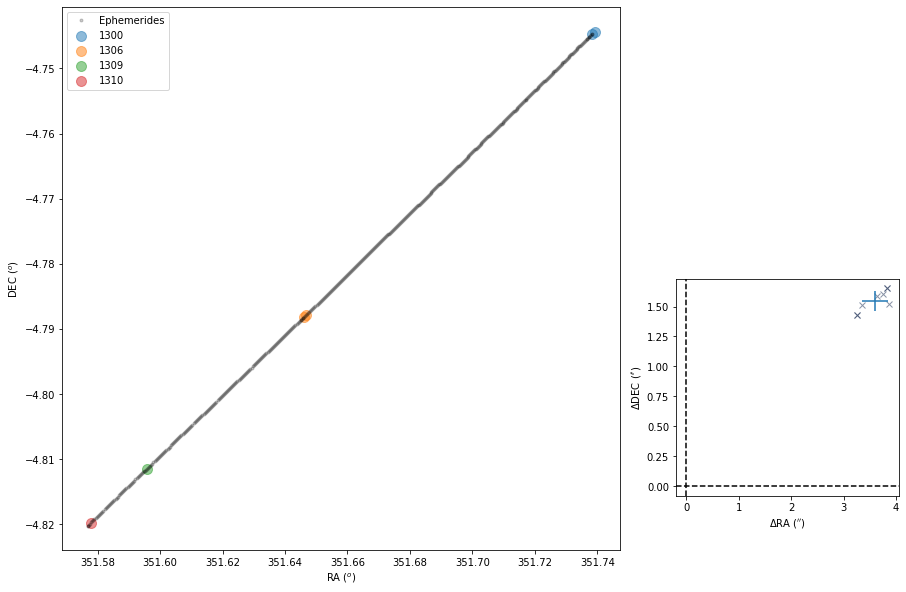

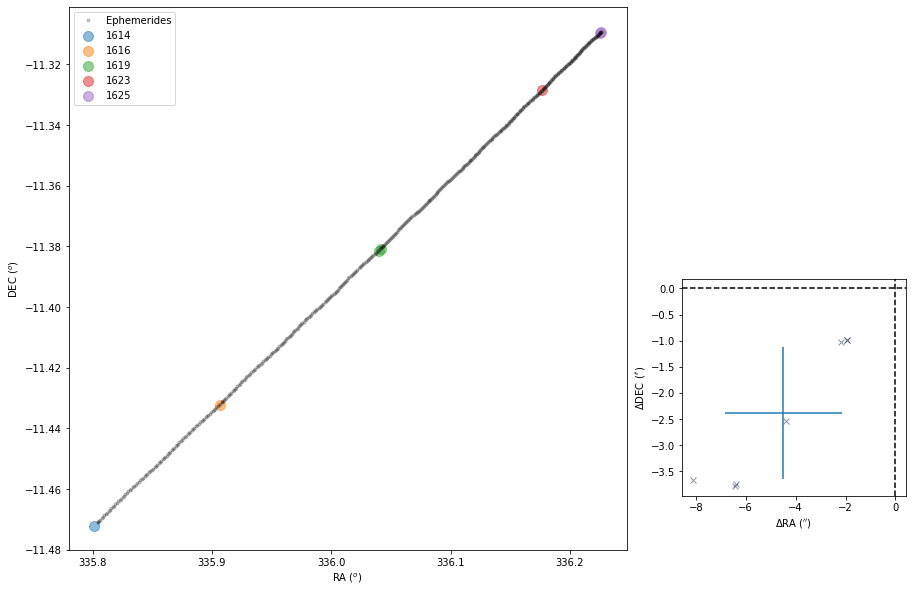

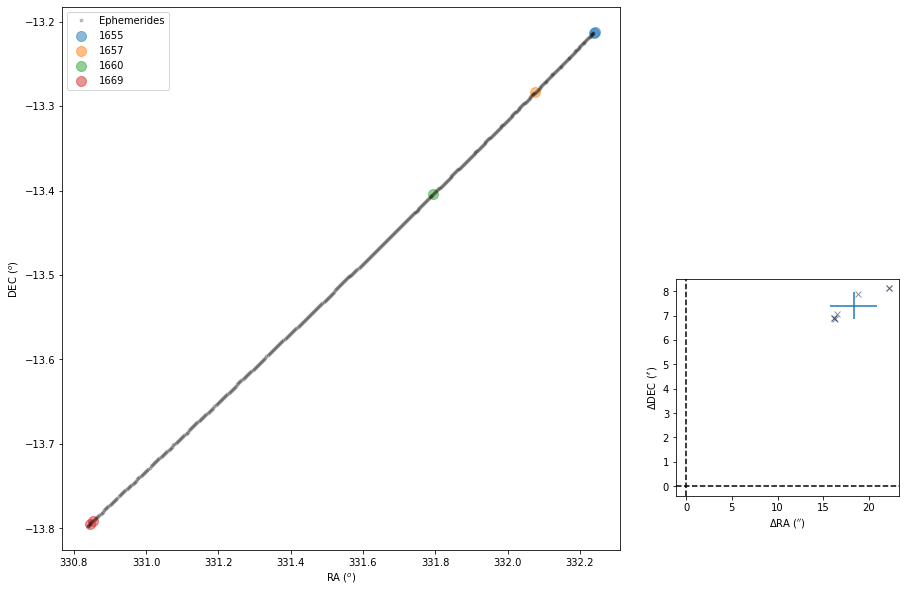

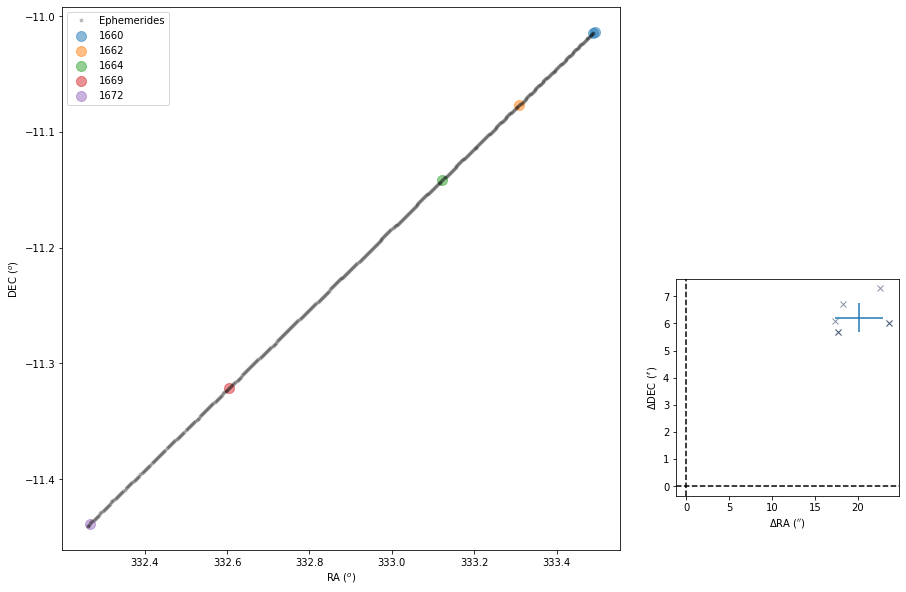

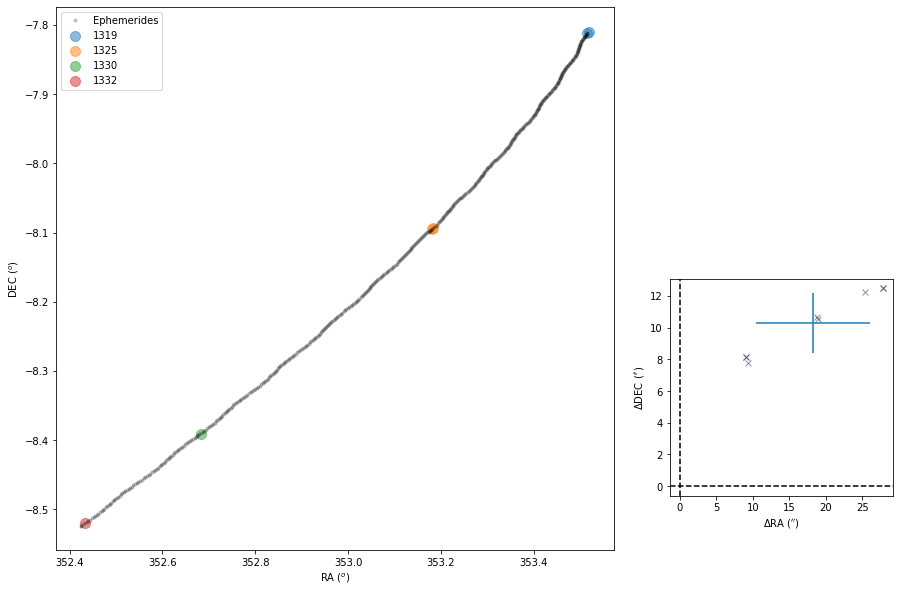

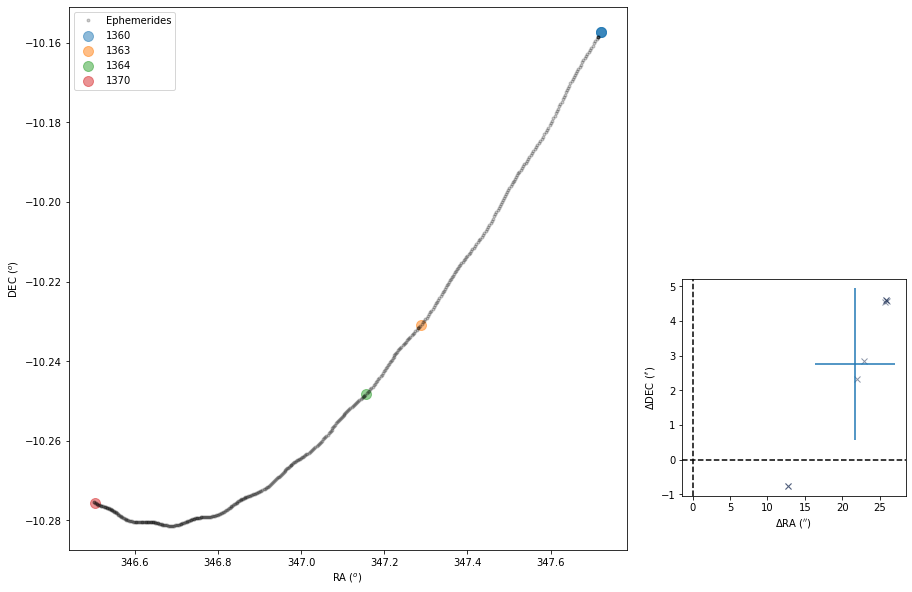

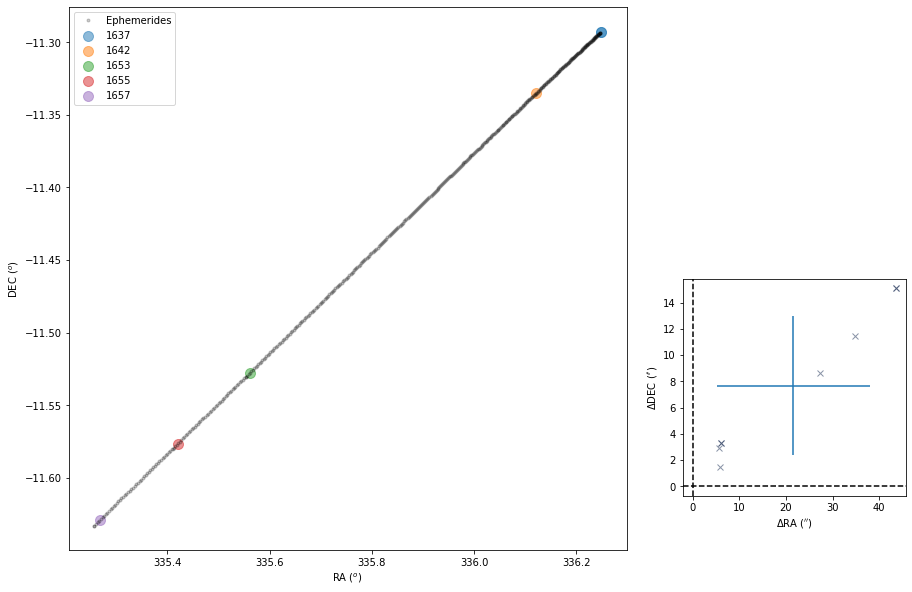

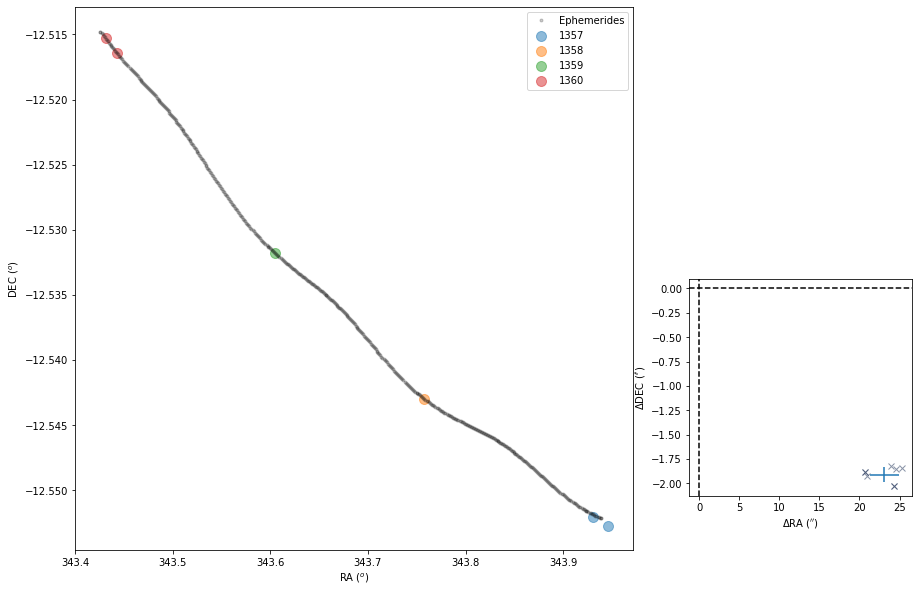

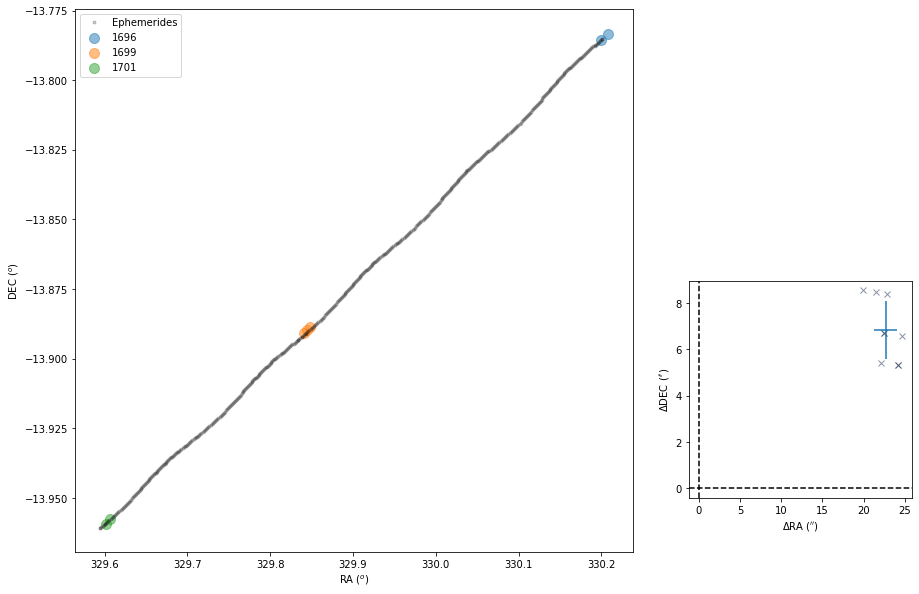

In [249]:
for tr_id in ephem_score["trajectory_id"].iloc[:10]:
    best_ephem = ephem_fit(orb_traj, tr_id, 500)
    best_traj = orb_traj[orb_traj["trajectory_id"] == tr_id]
    plot_ephem(best_traj.reset_index(drop=True), best_ephem.reset_index(drop=True))

In [303]:
ephem_score.iloc[-10:]

trajectory_id  mean_sep_error
97            3754       69.535729
98            4237       71.078088
99           55519       75.167364
100           3085       78.344686
101           3079       96.197762
102           1471      122.217903
103           1470      150.905736
104           4176      192.177773
105           4946      286.537440
106           4259      745.159274

### Plot worst orbits based on ephemeris score

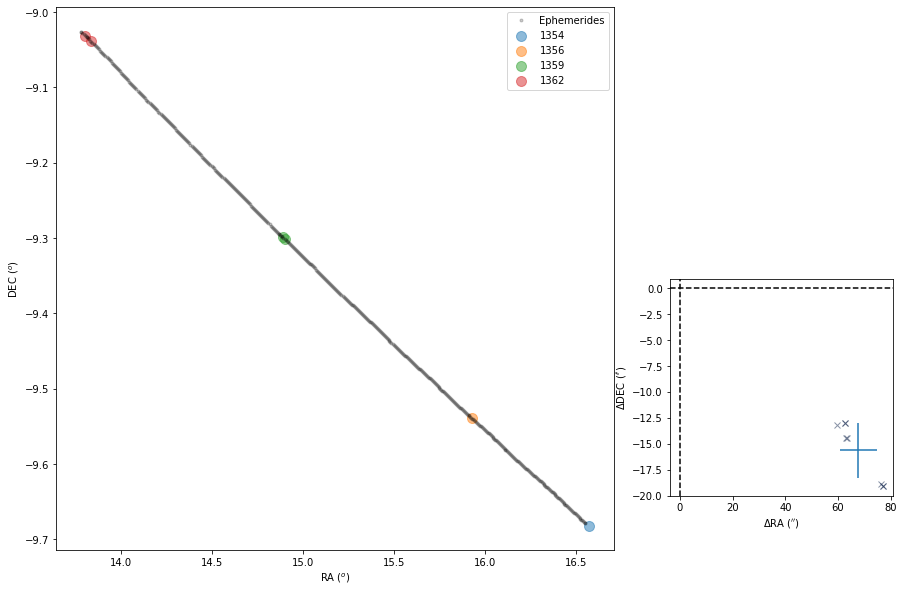

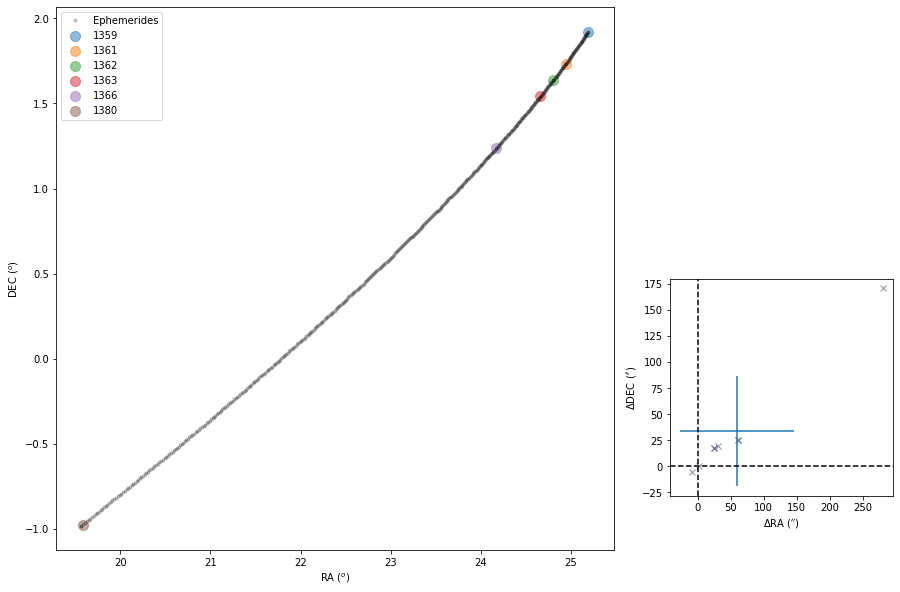

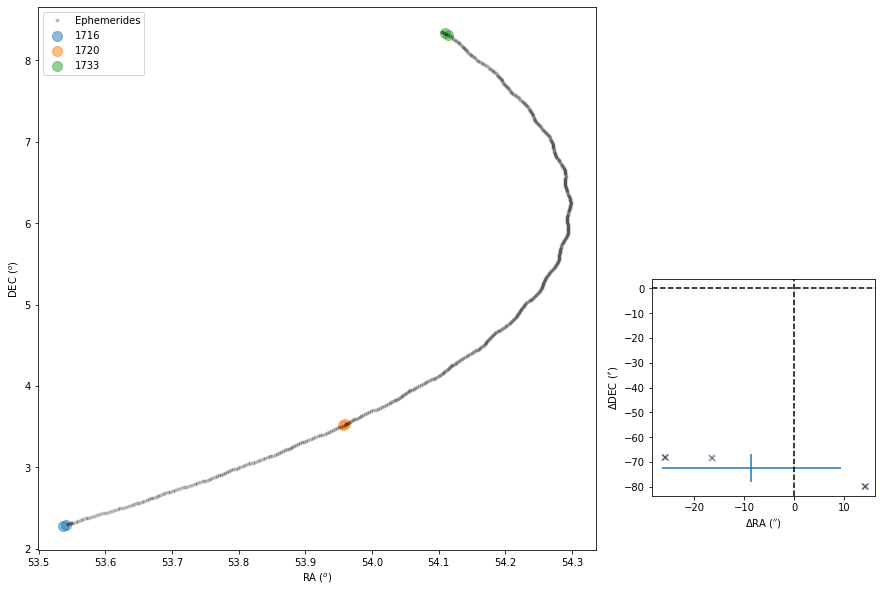

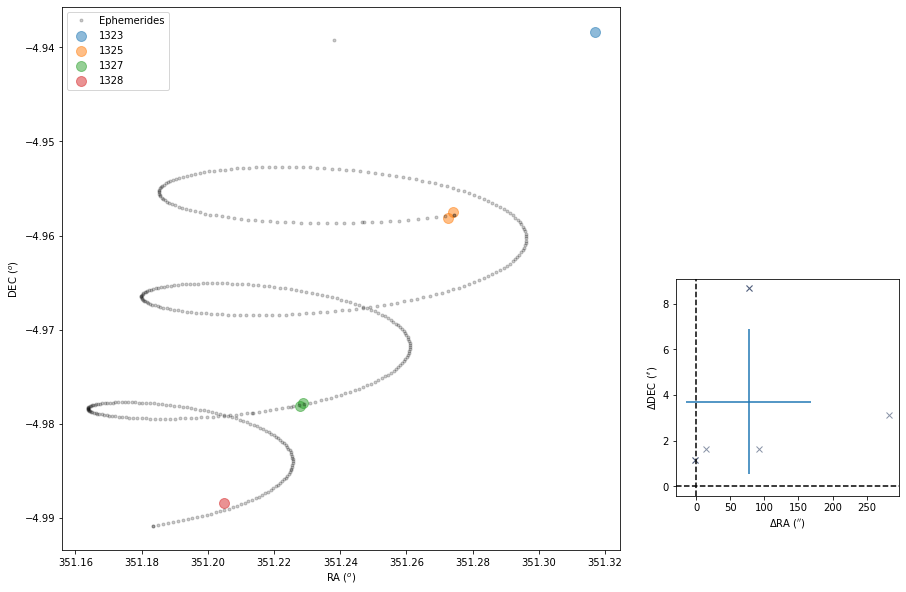

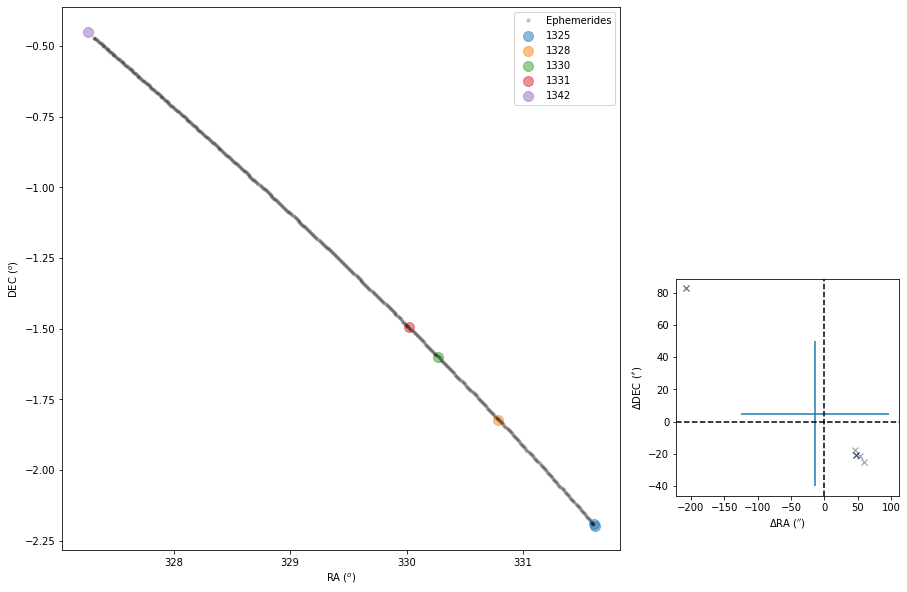

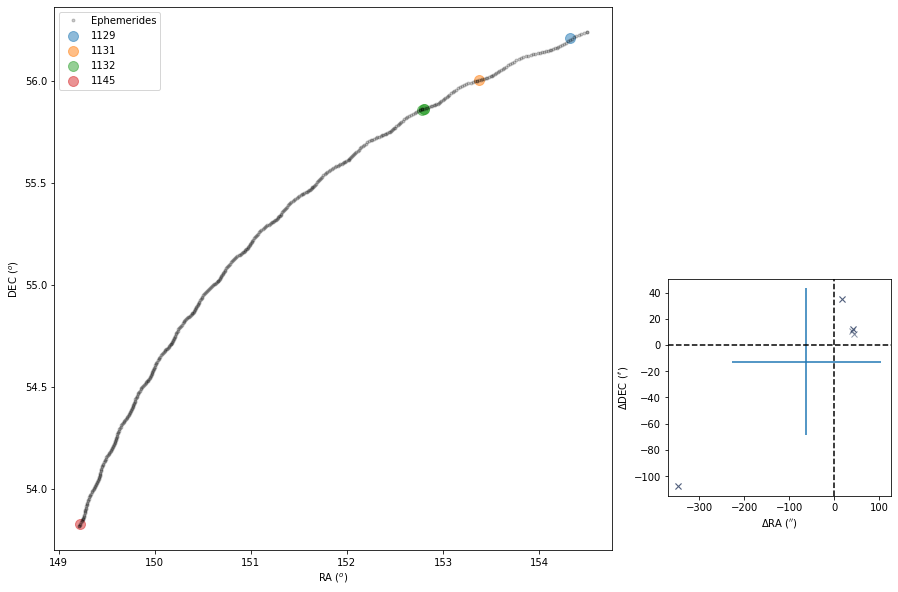

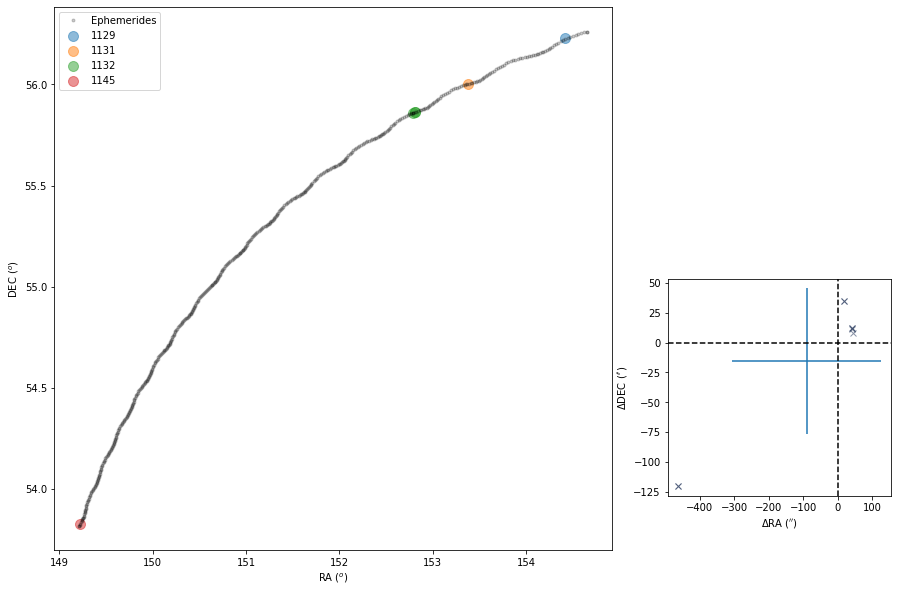

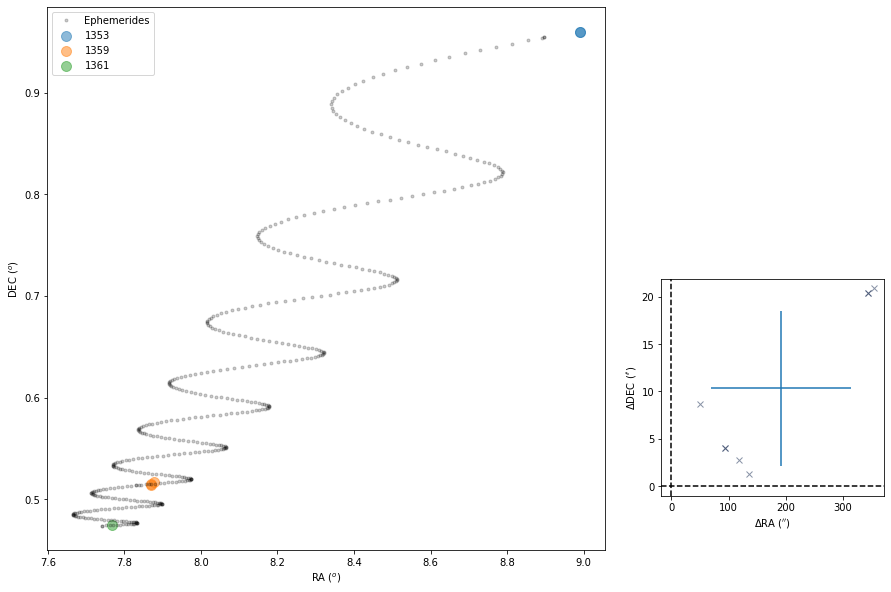

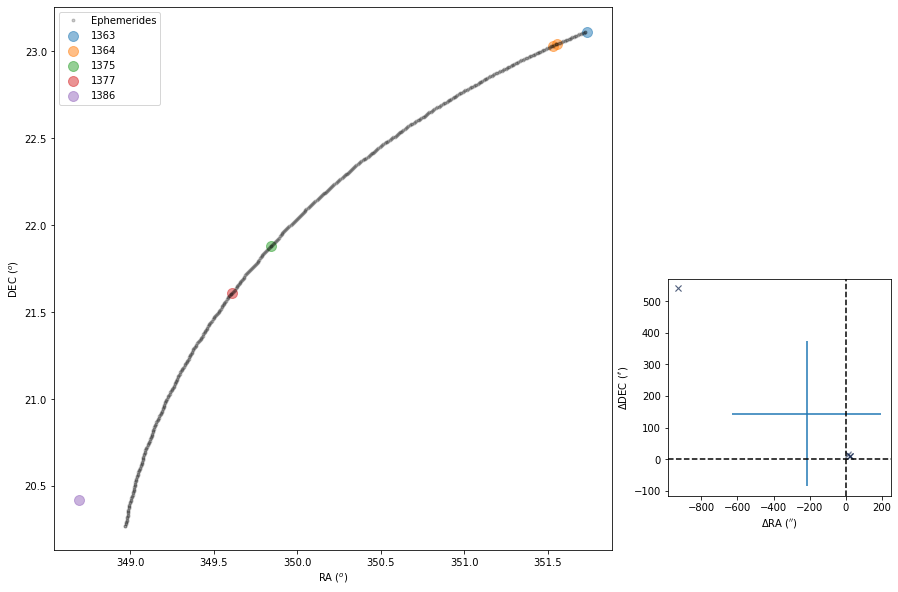

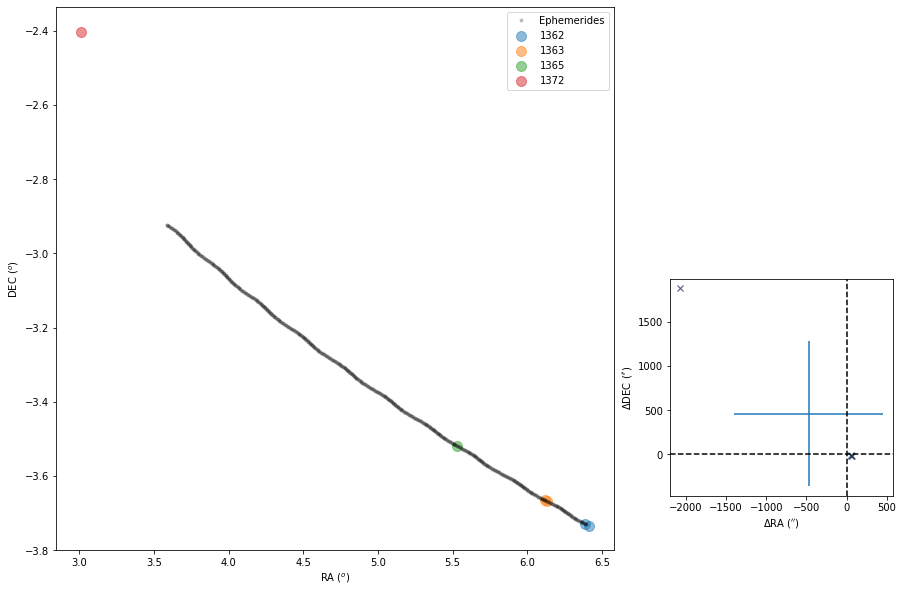

In [251]:
for tr_id in ephem_score["trajectory_id"].iloc[-10:]:
    worst_ephem = ephem_fit(orb_traj, tr_id, 500)
    worst_traj = orb_traj[orb_traj["trajectory_id"] == tr_id]
    plot_ephem(worst_traj.reset_index(drop=True), worst_ephem.reset_index(drop=True))

### Comparison of both score

In [293]:
best_both = quad_score.iloc[:10].merge(ephem_score.iloc[:10], on="trajectory_id")
best_both

trajectory_id     score  mean_sep_error
0           4064  1.911087       21.981747
1           2916  2.050970       21.119658

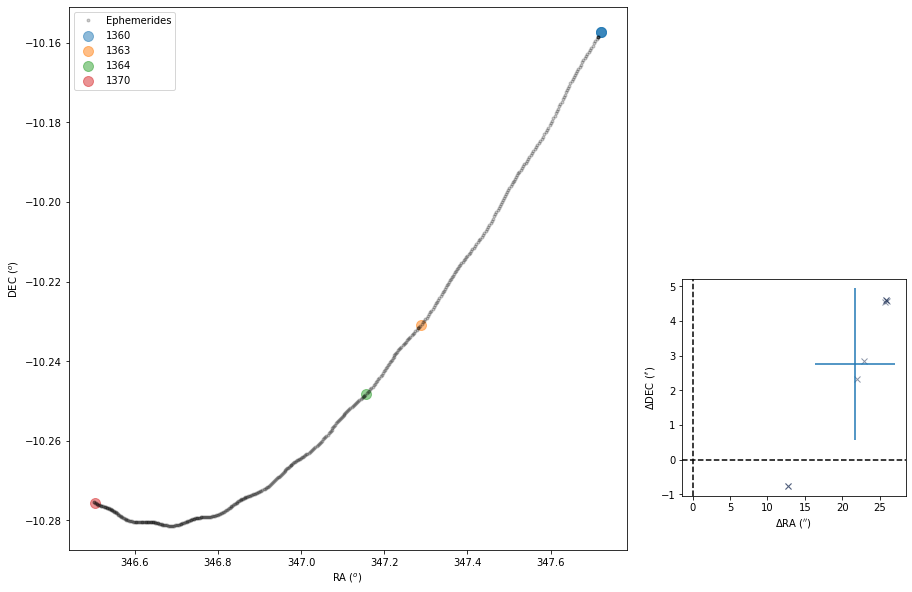

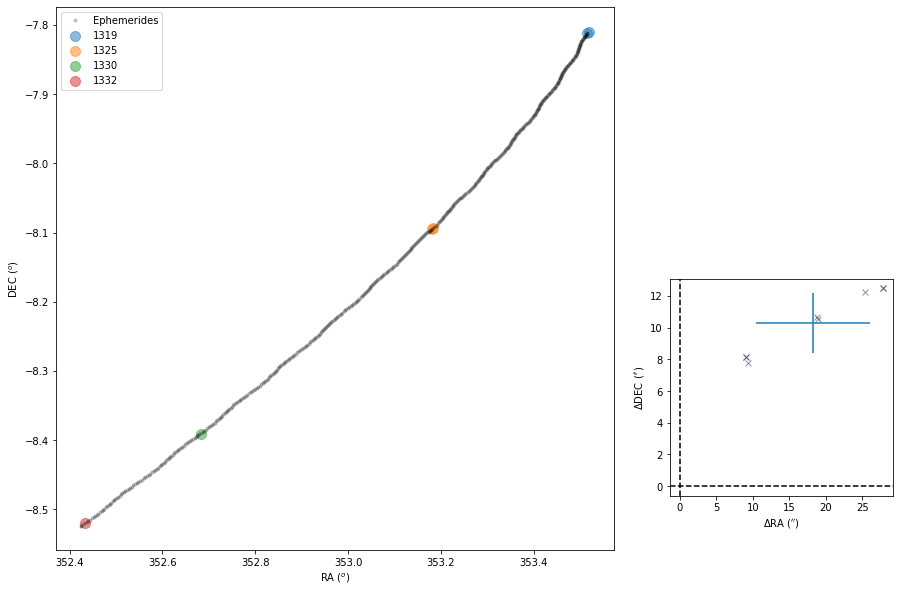

In [294]:
for tr_id in best_both["trajectory_id"]:
    best_ephem = ephem_fit(orb_traj, tr_id, 500)
    best_traj = orb_traj[orb_traj["trajectory_id"] == tr_id]
    plot_ephem(best_traj.reset_index(drop=True), best_ephem.reset_index(drop=True))

### Best quad score plots with ephemeris

42.403386100674894


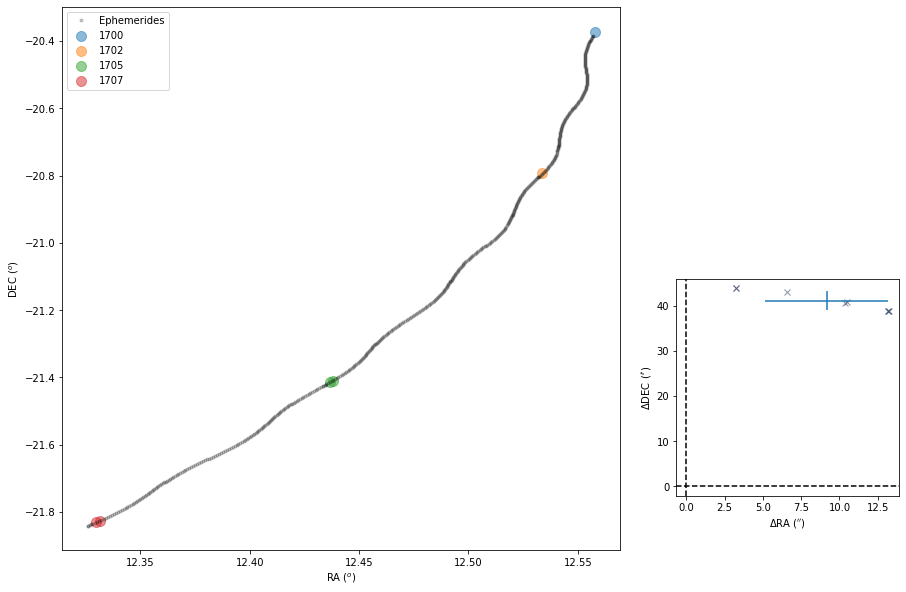

32.805142259790465


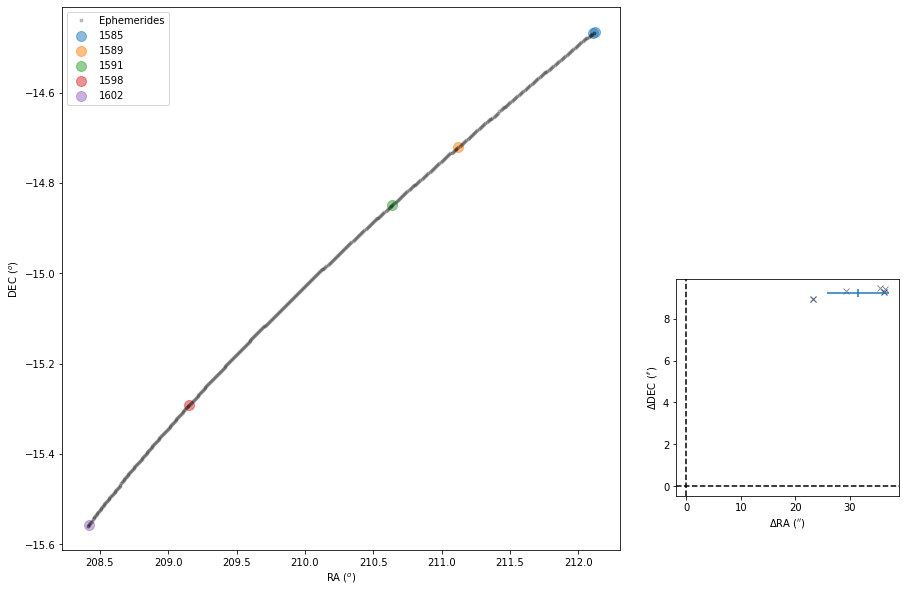

21.981746753892626


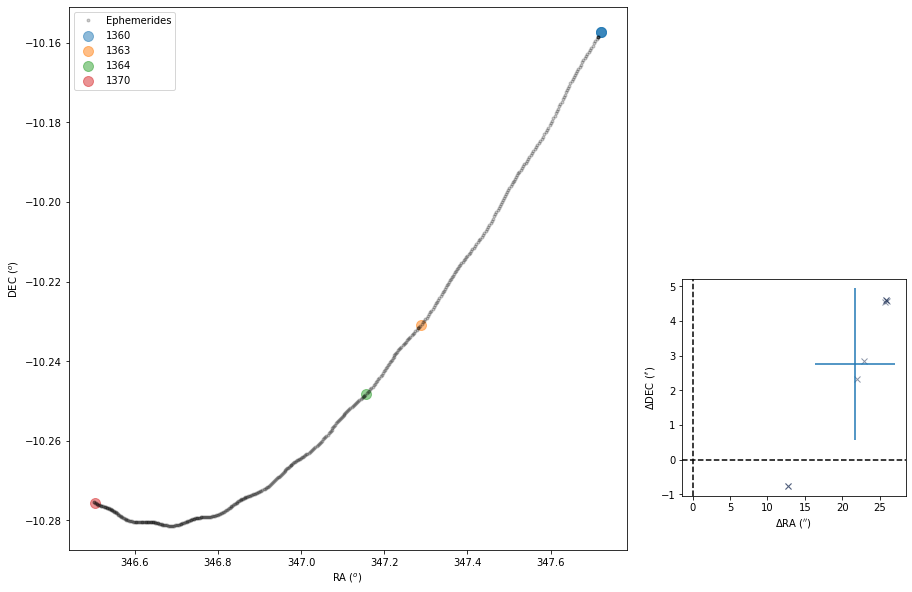

37.55577336995114


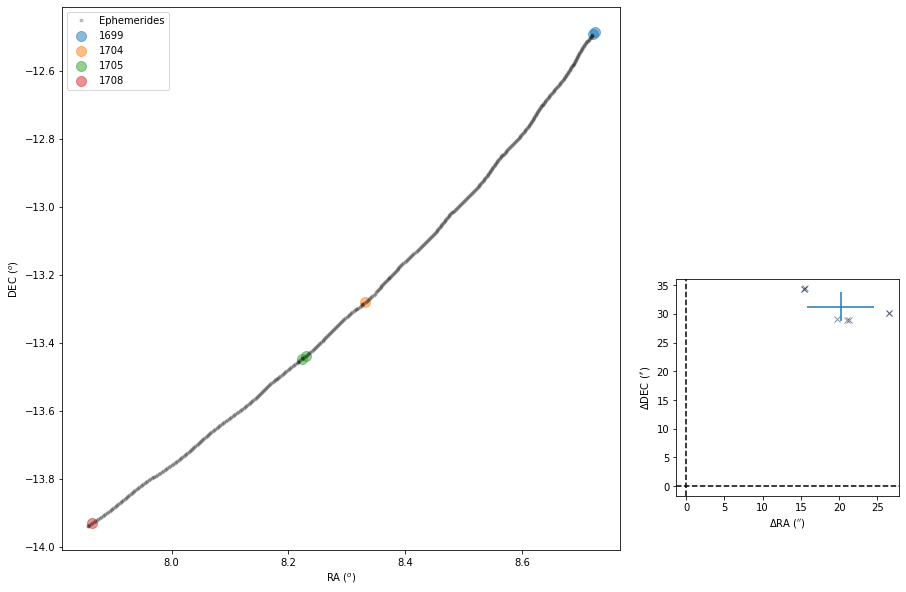

21.11965842308488


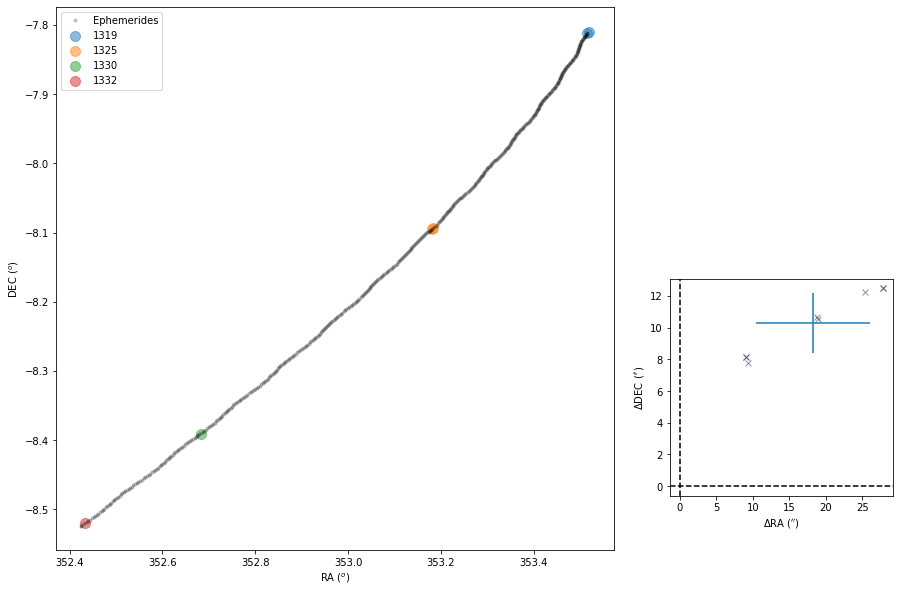

36.36572612473785


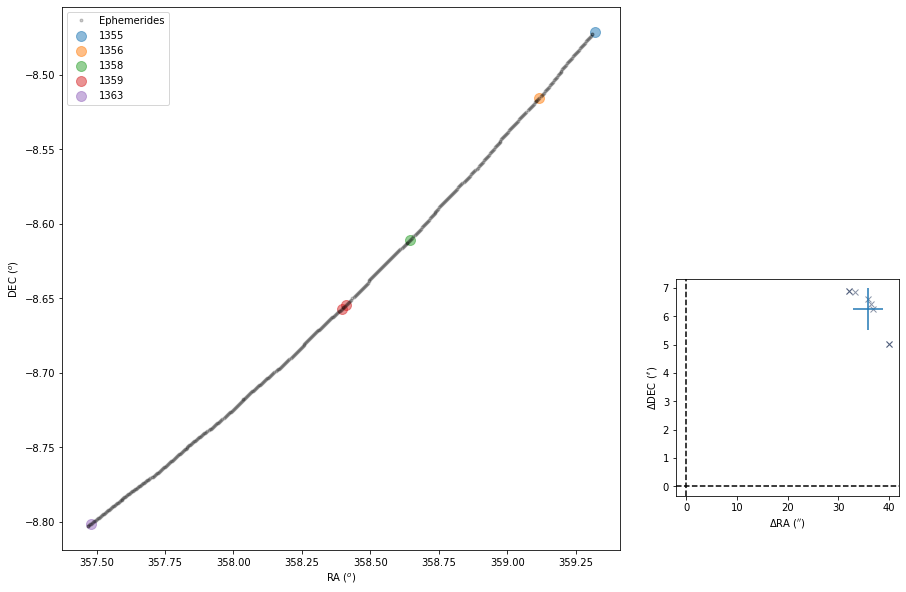

46.43293704246086


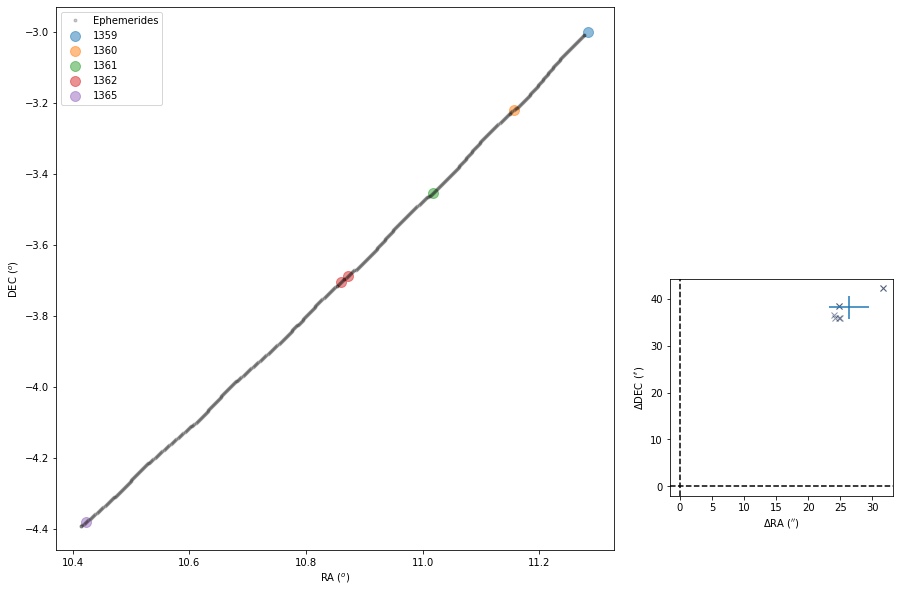

30.483488953842215


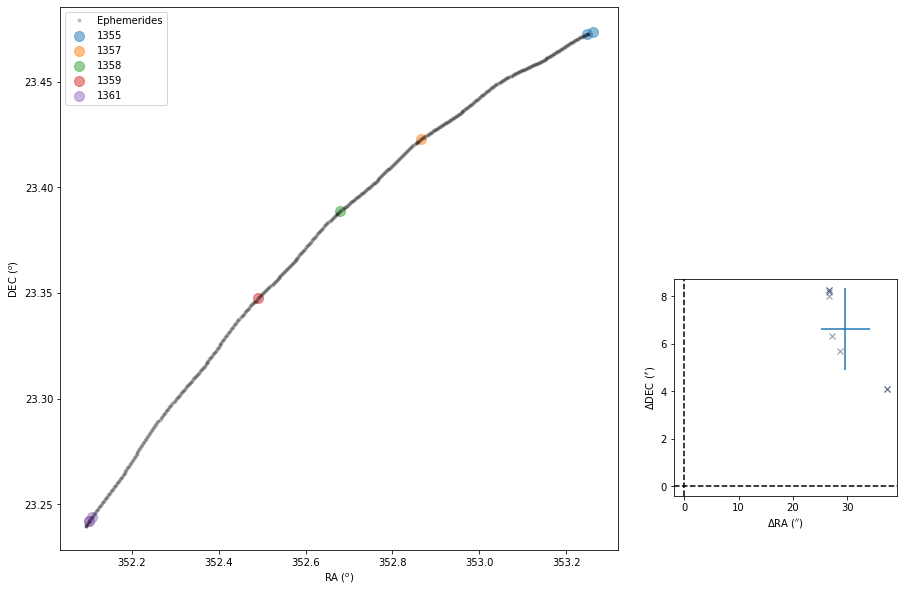

32.70607322836394


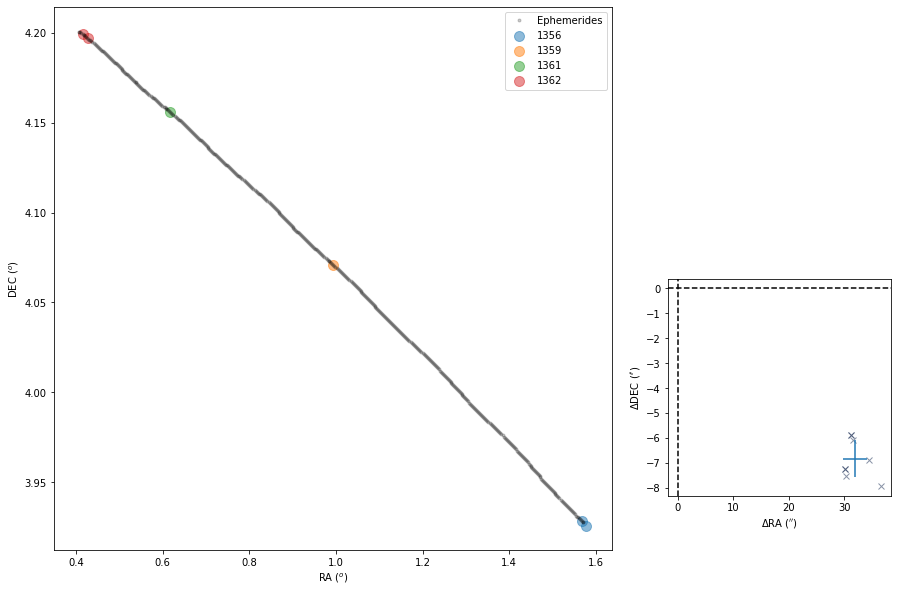

40.130375888173326


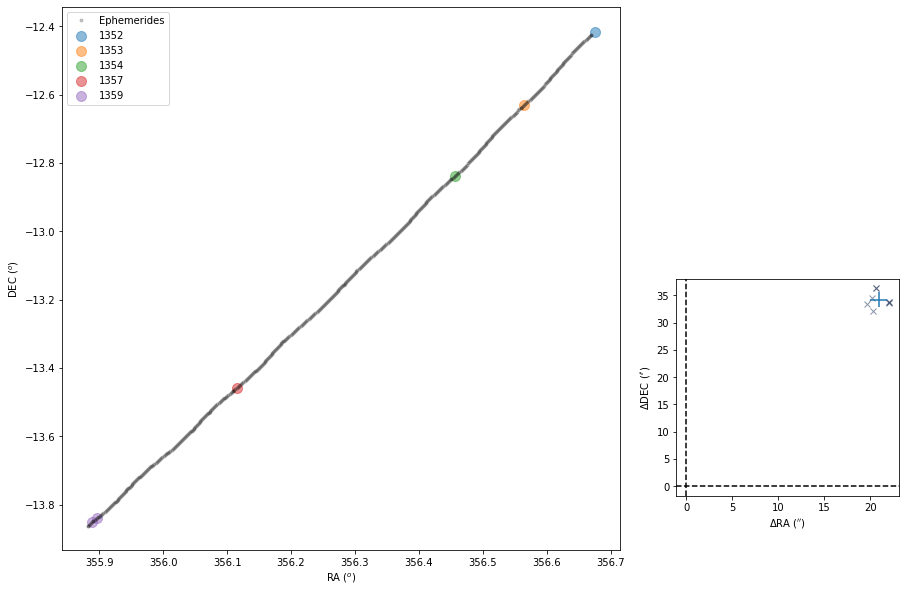

In [289]:
for tr_id in quad_score["trajectory_id"].iloc[:10]:
    best_ephem = ephem_fit(orb_traj, tr_id, 500)
    print(best_ephem["mean_sep_error"].iloc[0])
    best_traj = orb_traj[orb_traj["trajectory_id"] == tr_id]
    plot_ephem(best_traj.reset_index(drop=True), best_ephem.reset_index(drop=True))

### Worst quad score plots with ephemeris

286.5374396027618


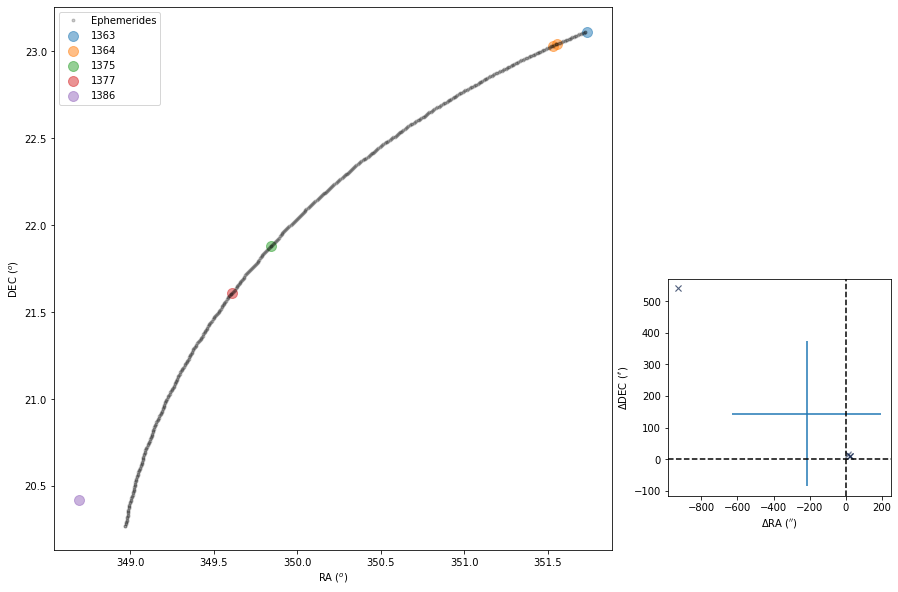

62.76296753562582


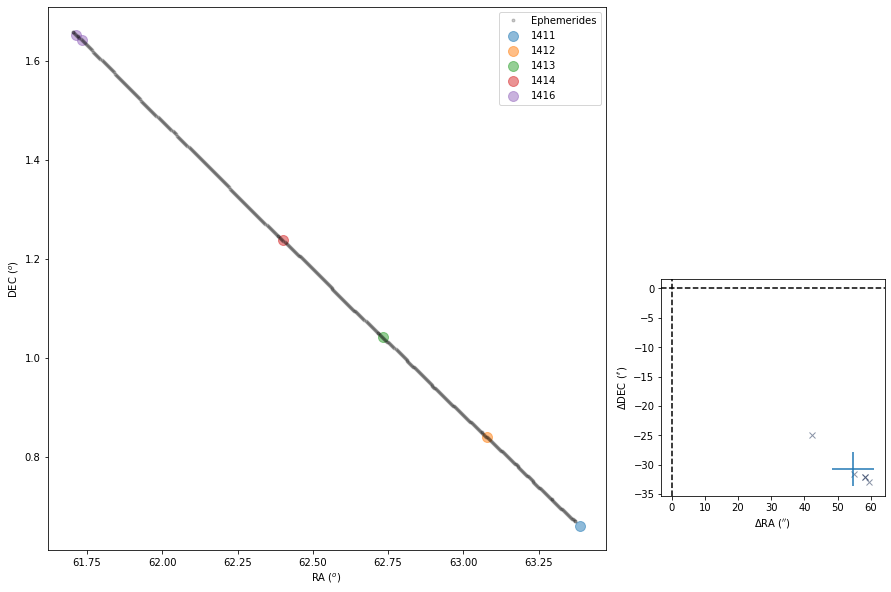

43.511065124758


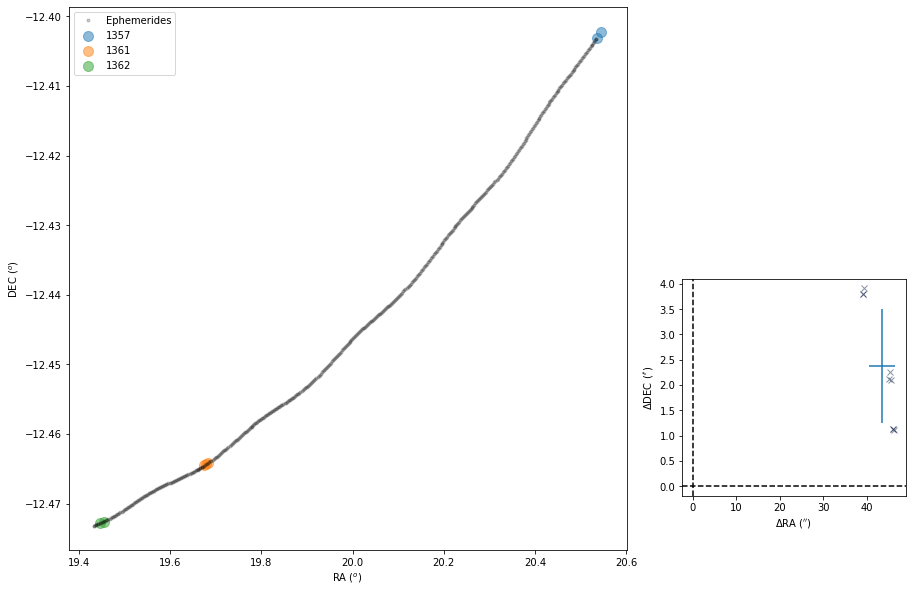

45.41838594459327


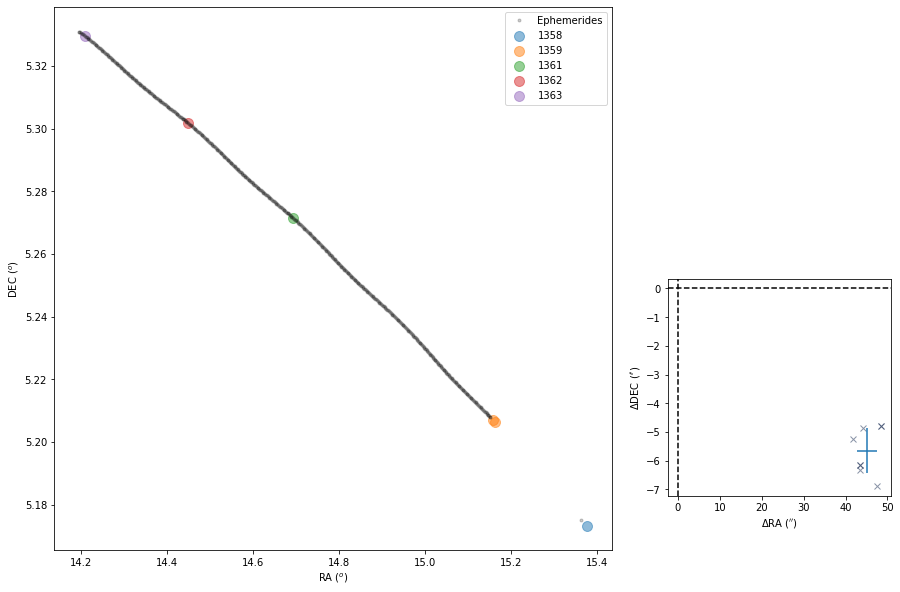

745.1592742561179


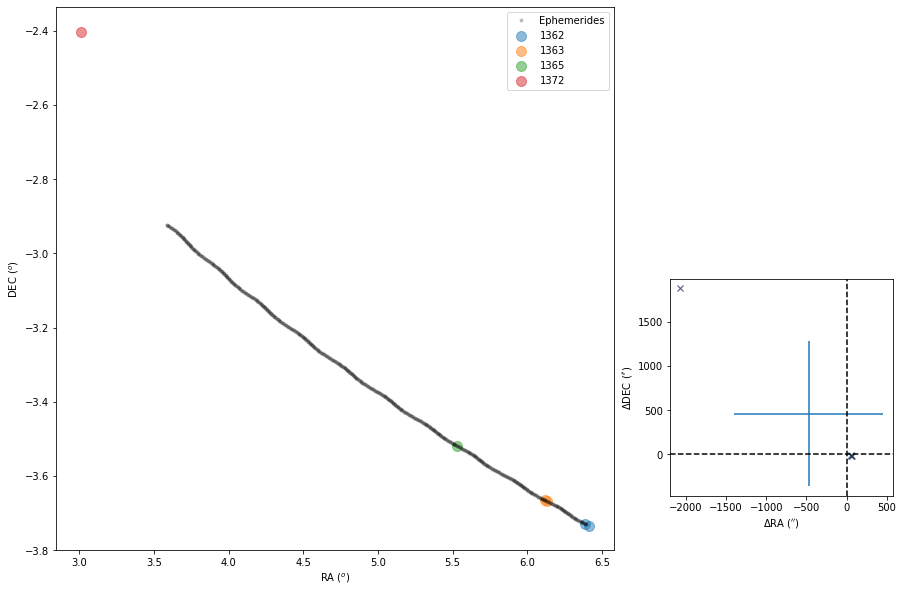

46.328242516650036


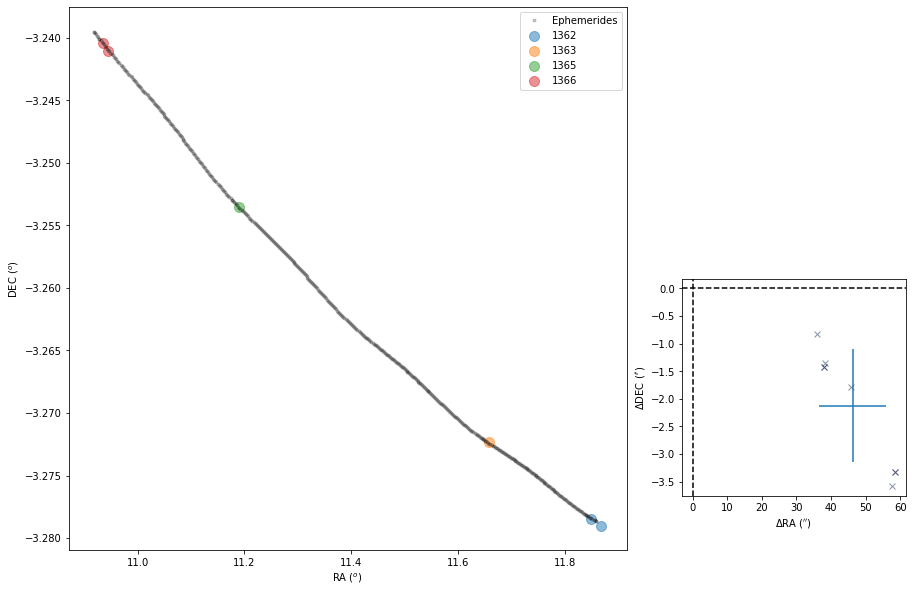

40.13662514966437


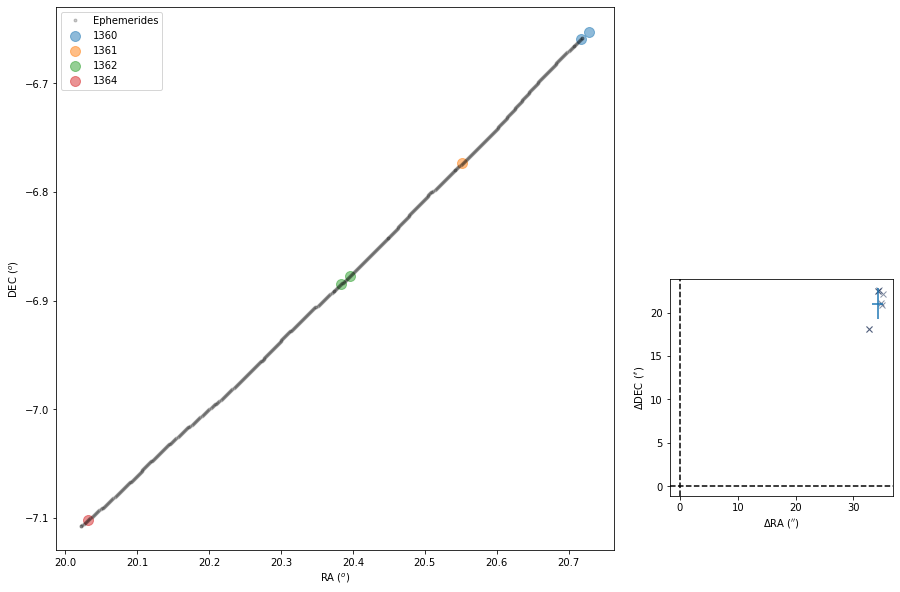

36.385727627896685


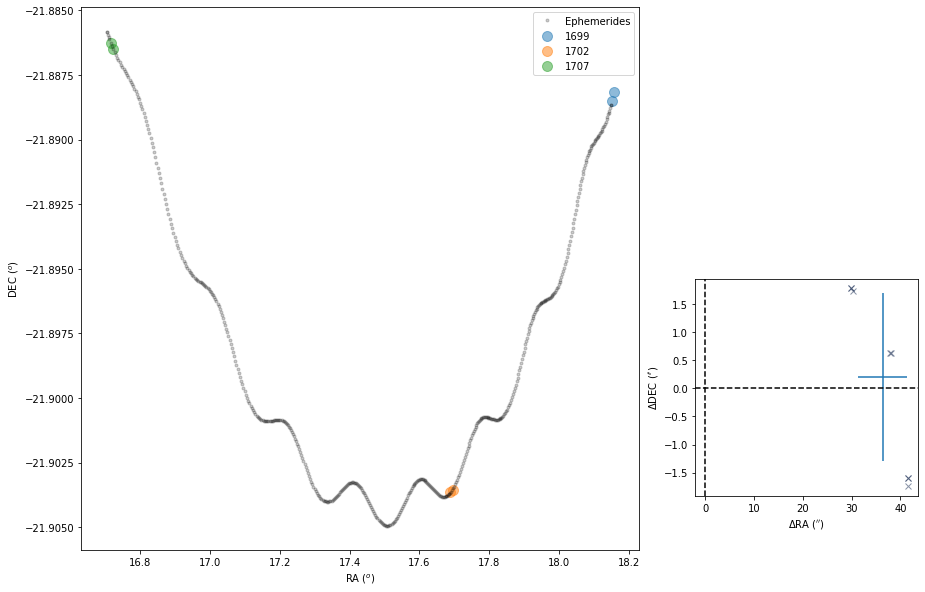

35.089757626657146


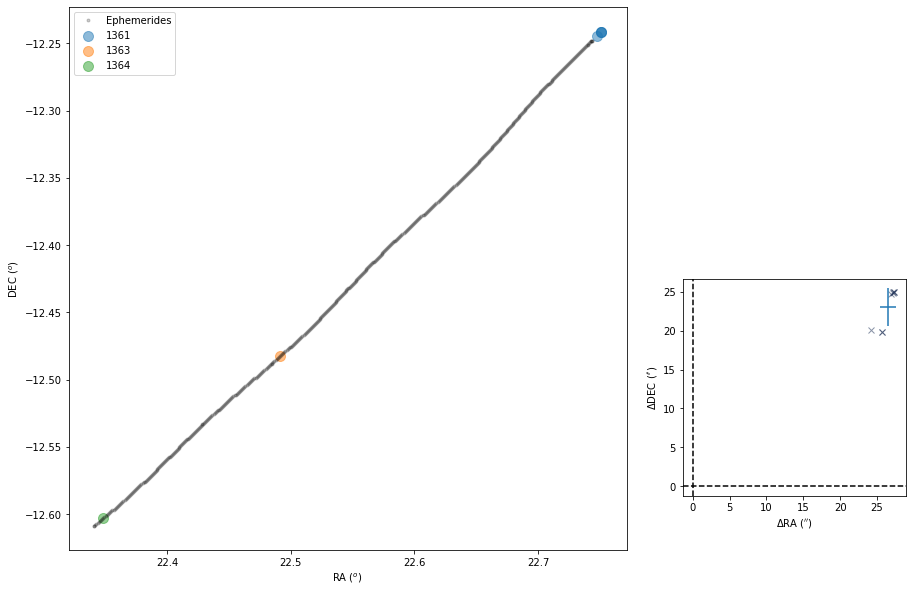

46.25521056364746


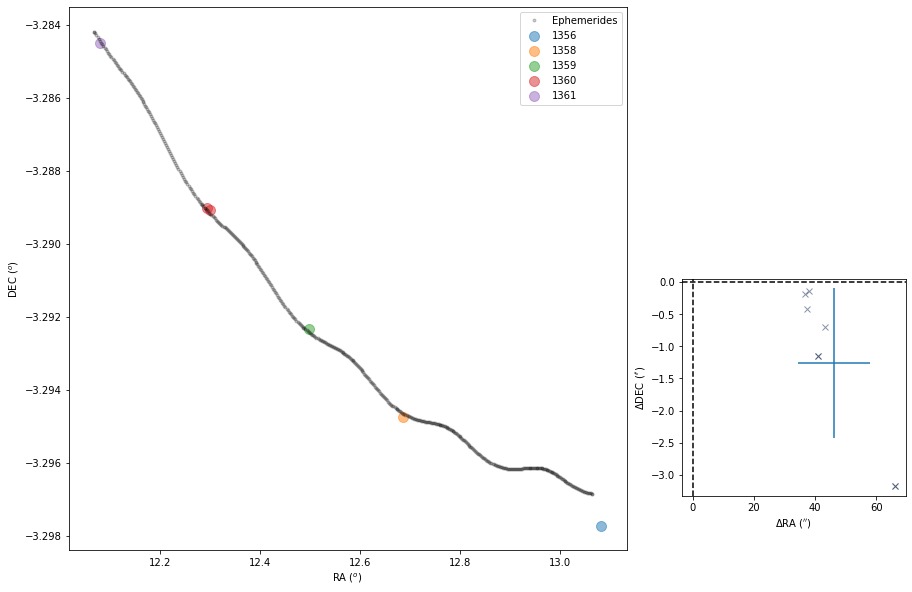

In [291]:
for tr_id in quad_score["trajectory_id"].iloc[-10:]:
    worst_ephem = ephem_fit(orb_traj, tr_id, 500)
    print(worst_ephem["mean_sep_error"].iloc[0])
    worst_traj = orb_traj[orb_traj["trajectory_id"] == tr_id]
    plot_ephem(worst_traj.reset_index(drop=True), worst_ephem.reset_index(drop=True))

## Special case

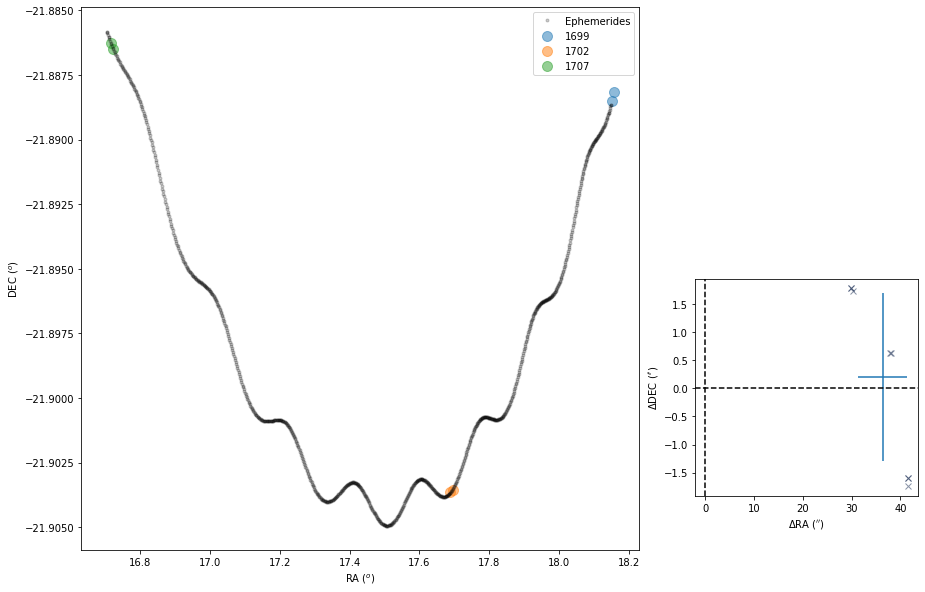

In [283]:
best_ephem = ephem_fit(orb_traj, 8354, 1000)
best_traj = orb_traj[orb_traj["trajectory_id"] == 8354]
plot_ephem(best_traj.reset_index(drop=True), best_ephem.reset_index(drop=True))

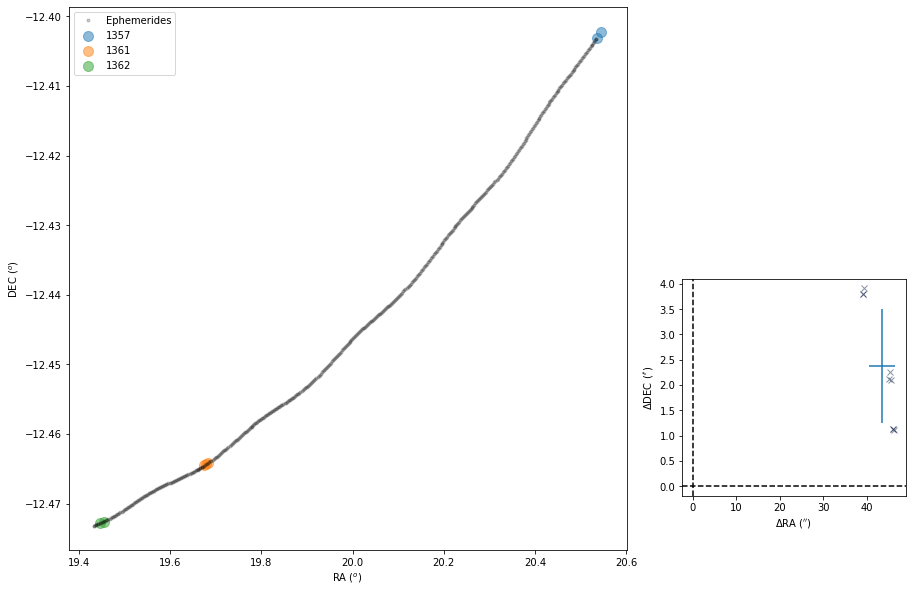

In [282]:
best_ephem = ephem_fit(orb_traj, 3764, 500)
best_traj = orb_traj[orb_traj["trajectory_id"] == 3764]
plot_ephem(best_traj.reset_index(drop=True), best_ephem.reset_index(drop=True))

### Using sbpy ephemeris (oorb backend)

In [27]:
def error_ephem(df_ephem):
    delta_ra = (df_ephem["ra"] - df_ephem["cRA"]) * np.cos(np.radians(df_ephem["dec"].astype(np.float64))) * 3600
    delta_dec = (df_ephem["dec"] - df_ephem["cDec"]) * 3600
    
    return delta_ra, delta_dec, distance.cdist(np.vstack([delta_ra, delta_dec]).T, [[0, 0]]).sum() / len(df_ephem)

def df_to_orb(df_orb):
    prep_to_orb = df_orb[["trajectory_id", "ref_epoch", "a", "e", "i", "long. node", "arg. peric", "mean anomaly"]].rename({
        "trajectory_id": "targetname",
        "long. node": "node",
        "arg. peric": "argper",
        "mean anomaly": "M",
        "ref_epoch": "epoch"
    },axis=1)

    prep_to_orb["orbtype"] = "KEP"

    prep_to_orb["H"] = 14.45
    prep_to_orb["G"] = 0.15


    orb_dict = prep_to_orb.to_dict(orient="list")

    orb_dict["a"] = orb_dict["a"] * u.au
    orb_dict["i"] = orb_dict["i"] * u.deg
    orb_dict["node"] = orb_dict["node"] * u.deg
    orb_dict["argper"] = orb_dict["argper"] * u.deg
    orb_dict["M"] = orb_dict["M"] * u.deg
    orb_dict["epoch"] = Time(orb_dict["epoch"], format="jd")
    orb_dict["H"] = orb_dict["H"] * u.mag

    ast_orb_db = Orbit.from_dict(orb_dict)
    return ast_orb_db


def fit_ephemeris(orb_data, traj_data, tr_id, num_pred=50):
    _orb = orb_data[orb_data["targetname"] == tr_id]
    current_traj = traj_data[traj_data["trajectory_id"] == tr_id].reset_index(drop=True)

    ephem_epochs=Time(current_traj["jd"], format="jd")

    ephem = Ephem.from_oo(_orb, epochs=ephem_epochs, location='I41', scope="basic").table.to_pandas()
    
    ephem_and_obs = pd.concat([current_traj, ephem], axis=1).rename({"RA": "cRA", "DEC": "cDec"}, axis=1)
    
    ephem_and_obs["delta_ra"], ephem_and_obs["delta_dec"], ephem_and_obs["ephem_score"] = error_ephem(ephem_and_obs)

    fit_ephem_epoch = Time(np.linspace(ephem_epochs[0].value, ephem_epochs[-1].value, num=num_pred), format="jd")
    ephem_fit = Ephem.from_oo(_orb, epochs=fit_ephem_epoch, location='I41', scope="basic").table.to_pandas().rename({"RA": "cRA", "DEC": "cDec"}, axis=1)
    
    ephem_and_obs = pd.concat([ephem_and_obs, ephem_fit])

    ephem_and_obs["Date"] = Time(ephem_and_obs["epoch"]).jd

    return ephem_and_obs.sort_values("Date")


def trajectory_ephem_score(orb_data, traj_data):
    traj_and_ephem = []
    for _orb in orb_data:
        current_traj = traj_data[traj_data["trajectory_id"] == _orb["targetname"].value[0]].reset_index(drop=True)
        ephem_epochs=Time(current_traj["jd"], format="jd")

        ephem = Ephem.from_oo(_orb, epochs=ephem_epochs, location='I41', scope="basic").table.to_pandas()
        tmp_tr_ephem = pd.concat([current_traj, ephem], axis=1).rename({"RA": "cRA", "DEC": "cDec"}, axis=1)
        tmp_tr_ephem["delta_ra"], tmp_tr_ephem["delta_dec"], tmp_tr_ephem["ephem_score"] = error_ephem(tmp_tr_ephem)
        traj_and_ephem.append(tmp_tr_ephem)

    traj_and_ephem = pd.concat(traj_and_ephem).reset_index(drop=True)
    return traj_and_ephem

In [28]:
candidate_orbit = df_to_orb(orb)

In [50]:
tr_ephem_with_score = trajectory_ephem_score(candidate_orbit, traj_orb).sort_values("ephem_score")

In [51]:
tr_ephem_with_score[["trajectory_id", "ephem_score"]]

trajectory_id    ephem_score
2078           7686       2.117236
2076           7686       2.117236
2075           7686       2.117236
2079           7686       2.117236
2080           7686       2.117236
...             ...            ...
2225          14806  311417.811111
2224          14806  311417.811111
2223          14806  311417.811111
2221          14806  311417.811111
2222          14806  311417.811111

[3574 rows x 2 columns]

In [244]:
tr_id = 345

orb_ex = candidate_orbit[candidate_orbit["targetname"] == tr_id]
tr_ex = traj_orb[traj_orb["trajectory_id"] == tr_id].reset_index(drop=True)

ephem_ex = Ephem.from_oo(orb_ex, epochs=Time(tr_ex["jd"], format="jd"), location='I41', scope="basic").table.to_pandas()

In [245]:
tr_ephem_ex = pd.concat([tr_ex, ephem_ex], axis=1).rename({"RA": "cRA", "DEC": "cDec"}, axis=1)

In [246]:
delta_ra = (tr_ephem_ex["ra"] - tr_ephem_ex["cRA"]) * np.cos(np.radians(tr_ephem_ex["dec"].astype(np.float64))) * 3600
delta_dec = (tr_ephem_ex["dec"] - tr_ephem_ex["cDec"]) * 3600

distance.cdist(np.vstack([delta_ra, delta_dec]).T, [[0, 0]]).sum() / len(tr_ephem_ex)

1040.5103169810366

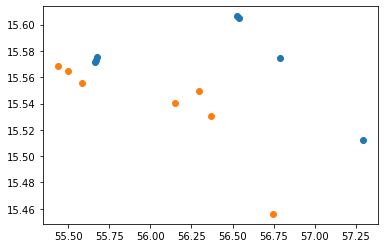

In [300]:
plt.scatter(tr_ex["ra"], tr_ex["dec"])
plt.scatter(ephem_ex["RA"], ephem_ex["DEC"])
plt.show()

In [129]:
from math import isnan

def plot_fit_ephem(ephem_fit):

    colors = ["#15284F", "#F5622E"]
    legend_size = 50

    fig, ax = plt.subplots(figsize=(20, 20), sharex=True,)

    # fig.suptitle(
    #     "Trajectories / ephemeris : {} trajectories of {} points".format(
    #         n_trajectories, n_points
    #     )
    # )

    ax.plot(
        ephem_fit["cRA"],
        ephem_fit["cDec"],
        ls="",
        color="black",
        marker=".",
        alpha=0.2,
        label="Ephemerides",
        markersize=12
    )

    for night in np.unique(ephem_fit["nid"]):
        if not isnan(night):
            current_night = ephem_fit[ephem_fit["nid"] == night]
            ax.scatter(
                current_night["ra"],
                current_night["dec"],
                label="ZTF night = {}".format(int(night)),
                alpha=0.7,
                s=400
            )

    ax.legend(loc="best", prop={'size': 20})
    ax.set_xlabel("RA ($^o$)", fontsize=legend_size)
    ax.set_ylabel("DEC ($^o$)", fontsize=legend_size)

    fig.suptitle("New SSO candidate number {} \n and the associated ephemeris".format(ephem_fit["targetname"].values[0]),y=1, fontsize=legend_size)

    axins = ax.inset_axes([1.3, 0.1, 0.40, 0.40])

    axins.plot(ephem_fit["delta_ra"], ephem_fit["delta_dec"], ls="", color=colors[0], marker="x", alpha=0.5)
    axins.errorbar(
        np.mean(ephem_fit["delta_ra"]),
        np.mean(ephem_fit["delta_dec"]),
        xerr=np.std(ephem_fit["delta_ra"]),
        yerr=np.std(ephem_fit["delta_dec"]),
    )
    axins.axhline(0, ls="--", color="black")
    axins.axvline(0, ls="--", color="black")
    axins.tick_params(axis='x', labelsize=legend_size)
    axins.tick_params(axis='y', labelsize=legend_size)
    axins.set_xlabel(r"$\Delta$RA ($^{\prime\prime}$)", fontsize=legend_size)
    axins.set_ylabel(r"$\Delta$DEC ($^{\prime\prime}$)", fontsize=legend_size)

    axins.set_title("Astrometry", fontsize=legend_size)

    ax.tick_params(axis='x', labelsize=legend_size)
    ax.tick_params(axis='y', labelsize=legend_size)

    plt.show()

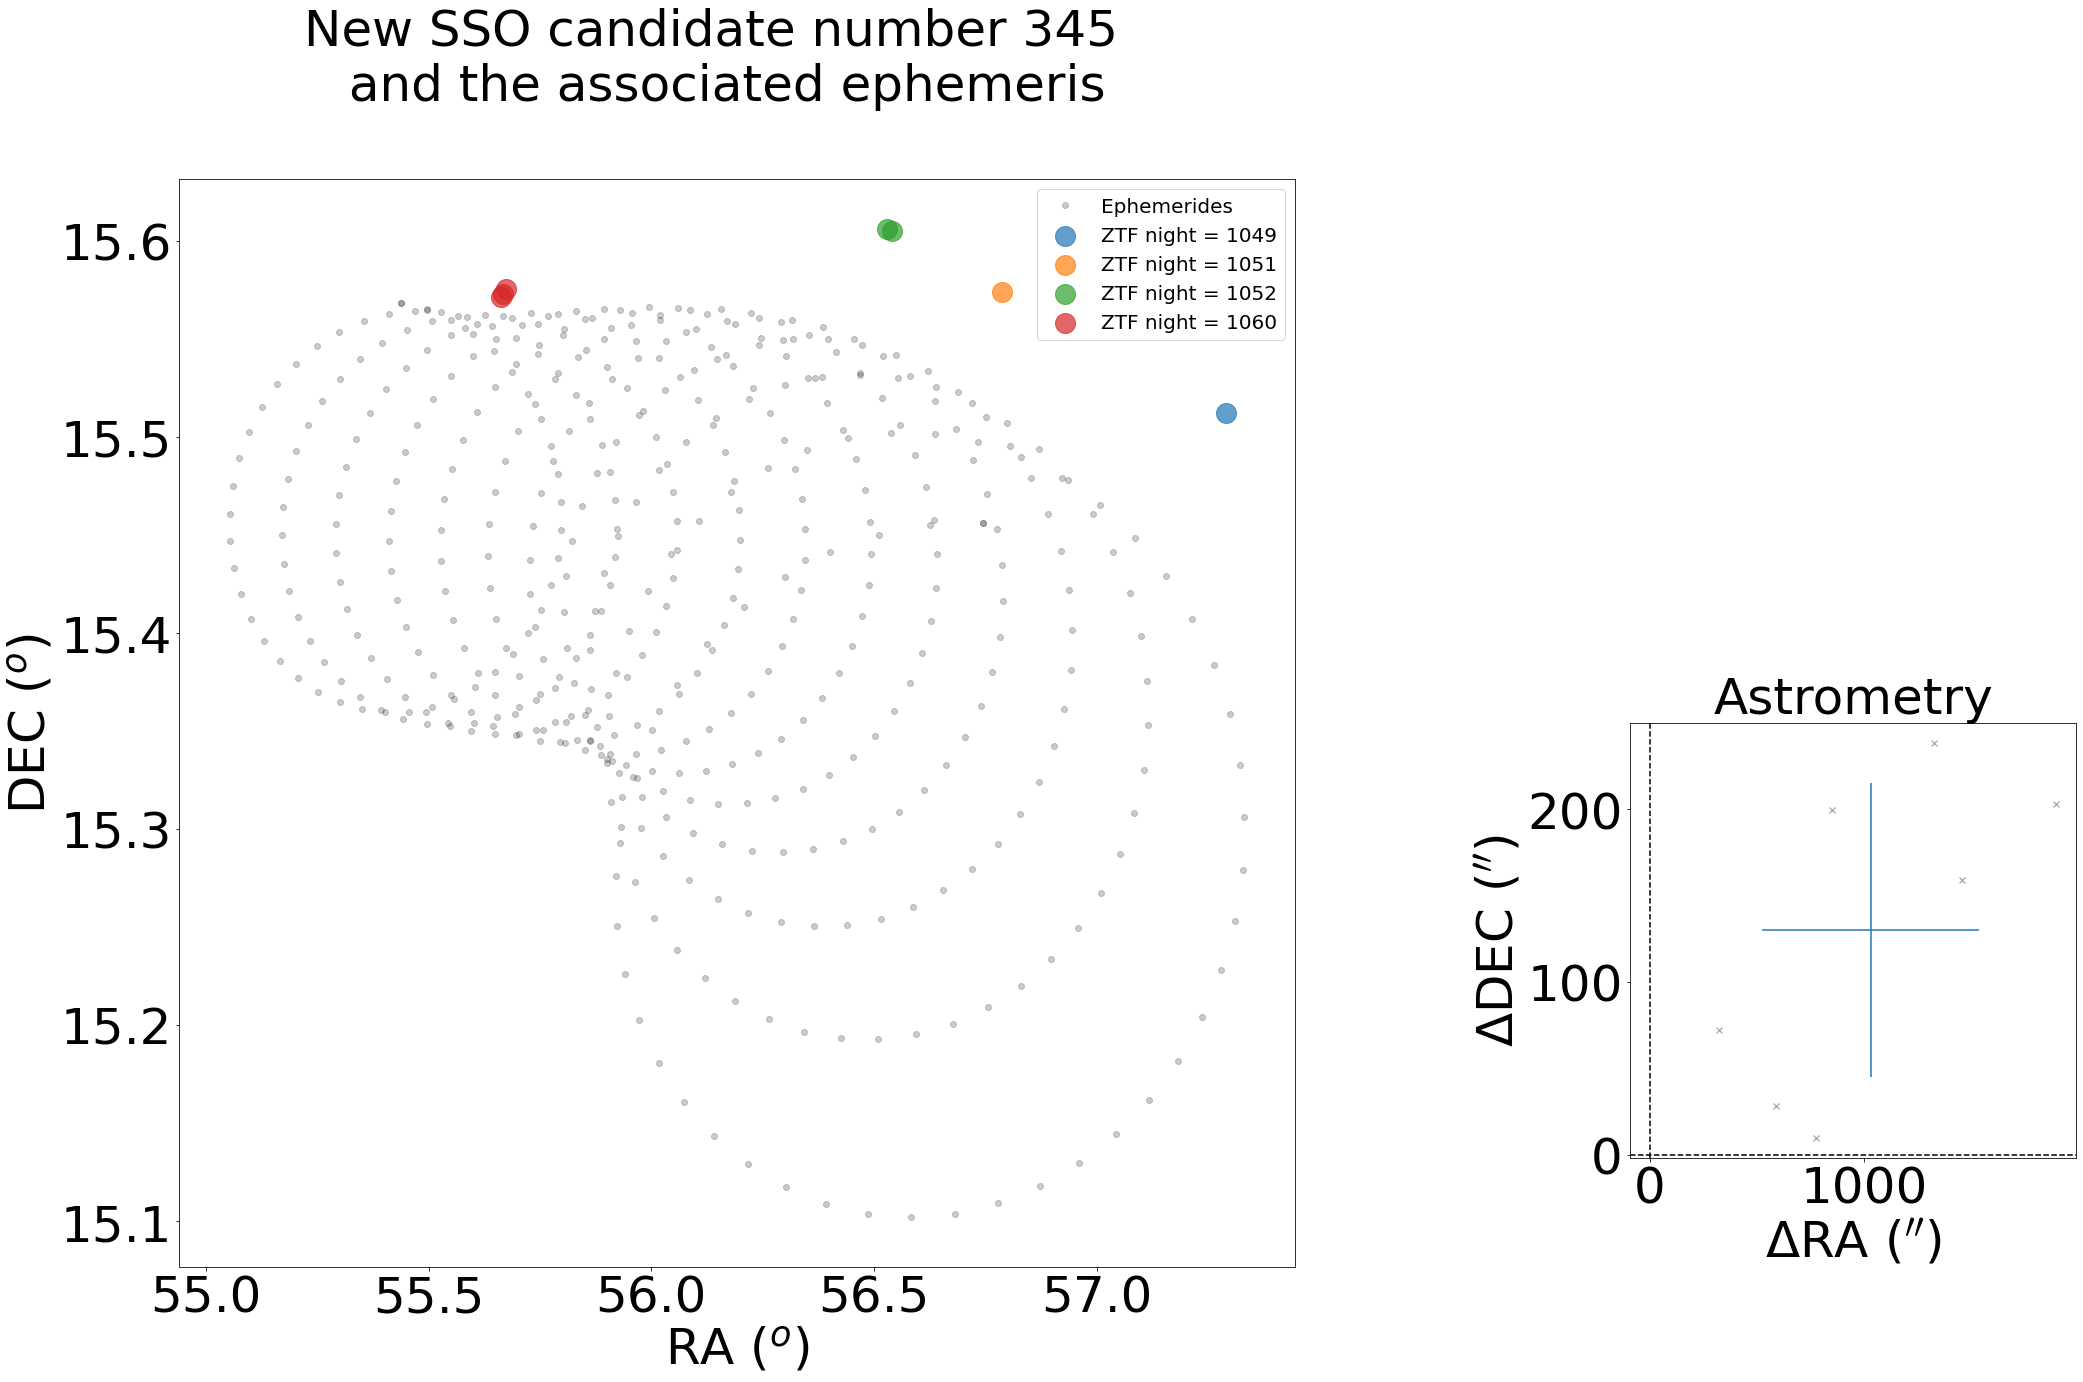

In [134]:
example_fit = fit_ephemeris(candidate_orbit, traj_orb, 345, 500)
plot_fit_ephem(example_fit)

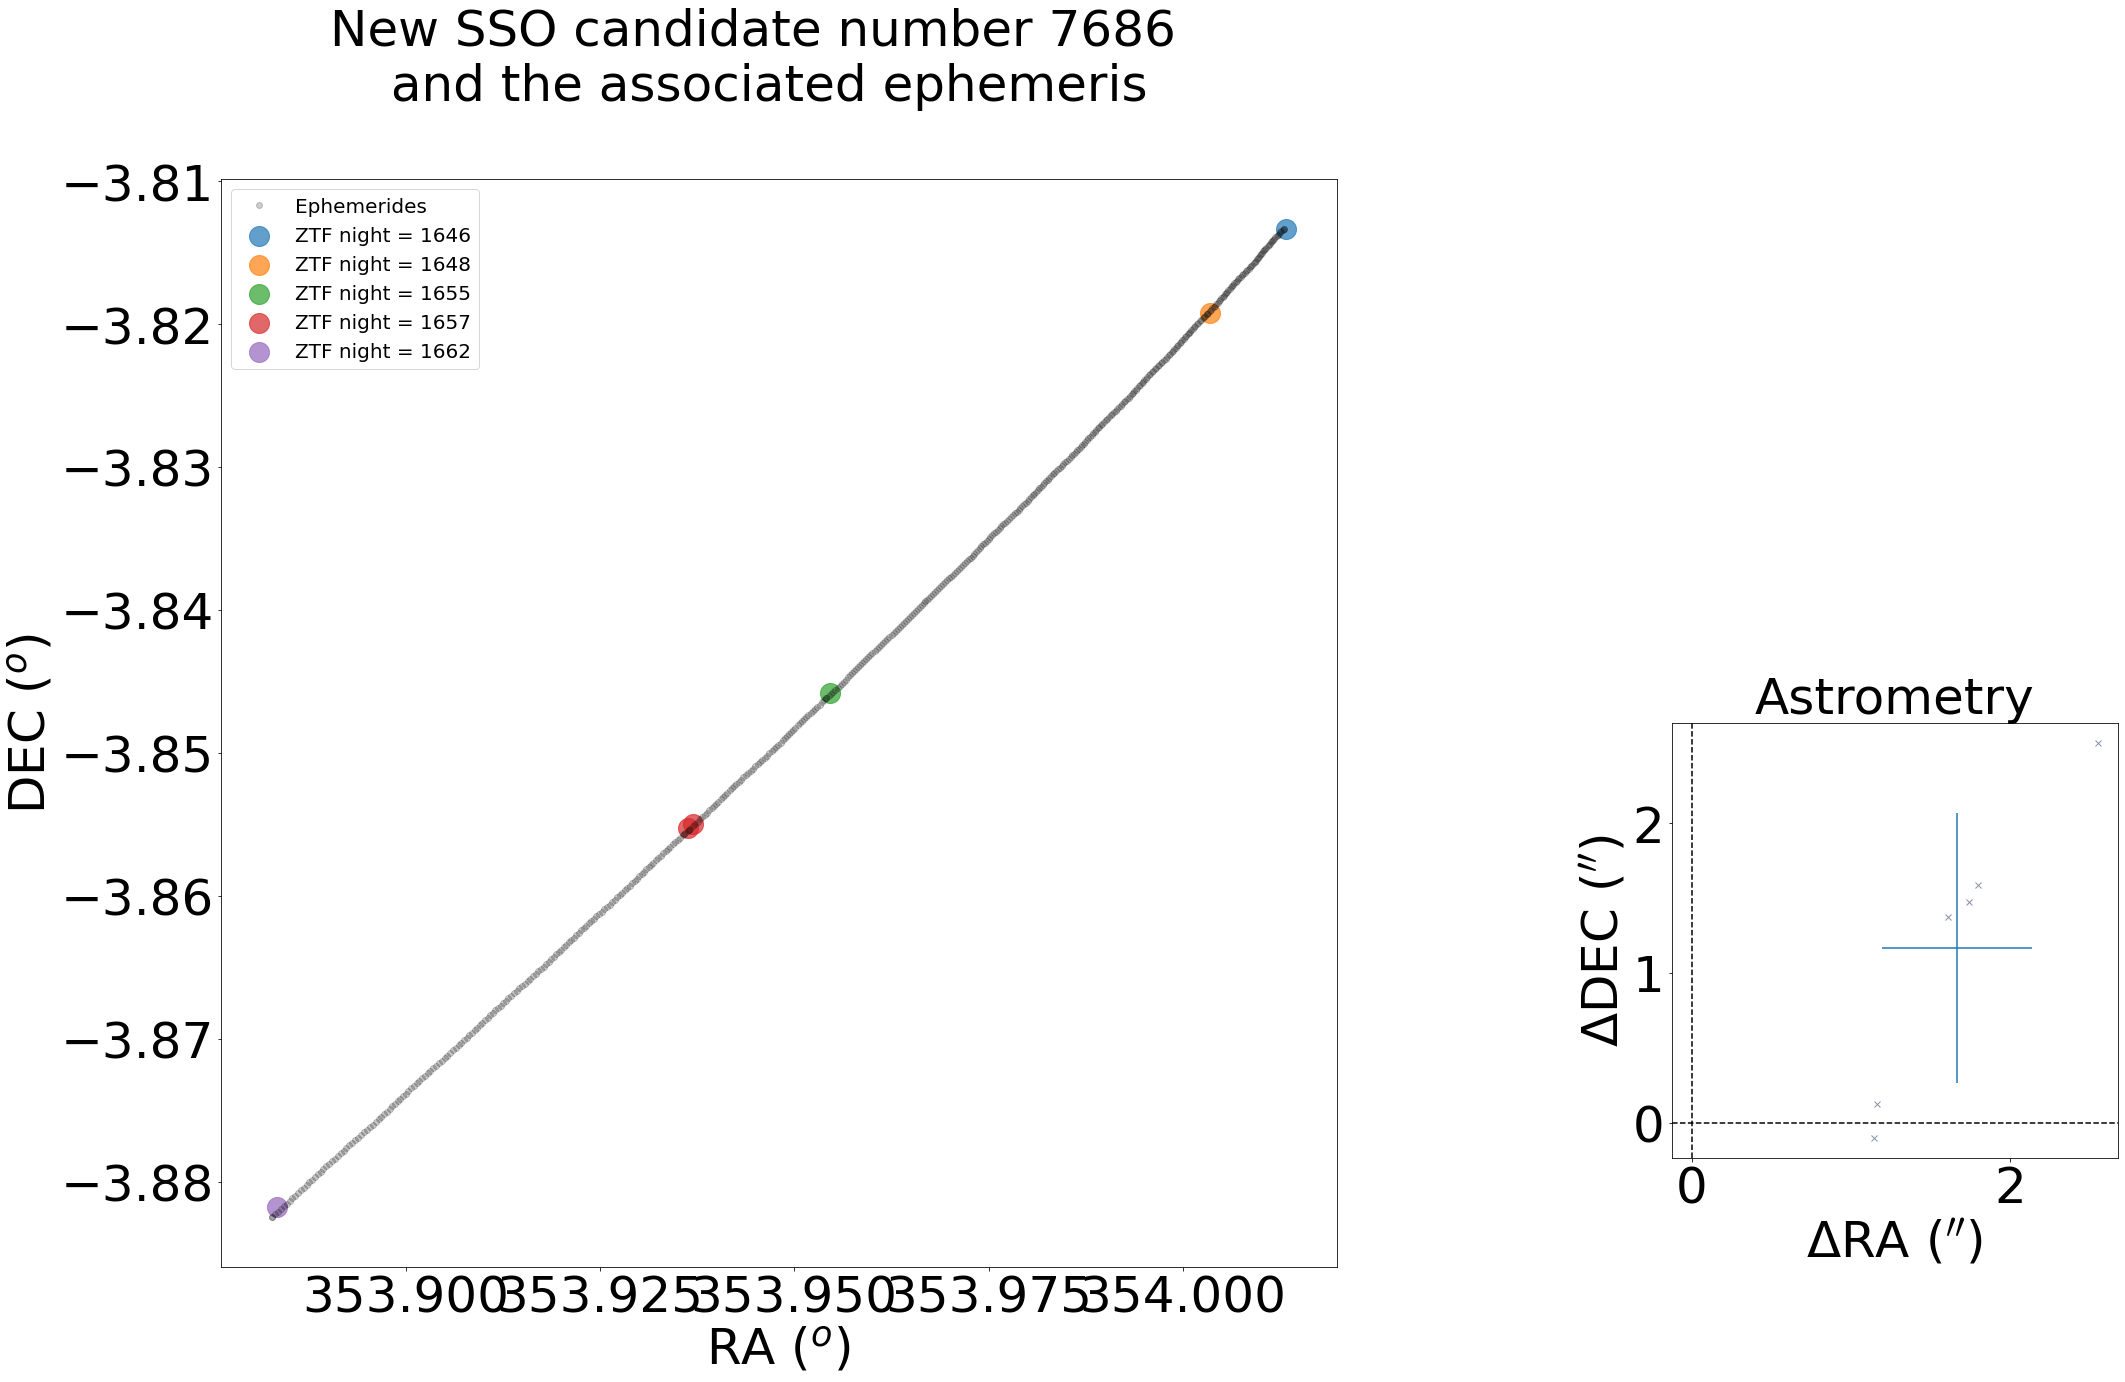

In [131]:
example_fit = fit_ephemeris(candidate_orbit, traj_orb, 7686, 500)
plot_fit_ephem(example_fit)

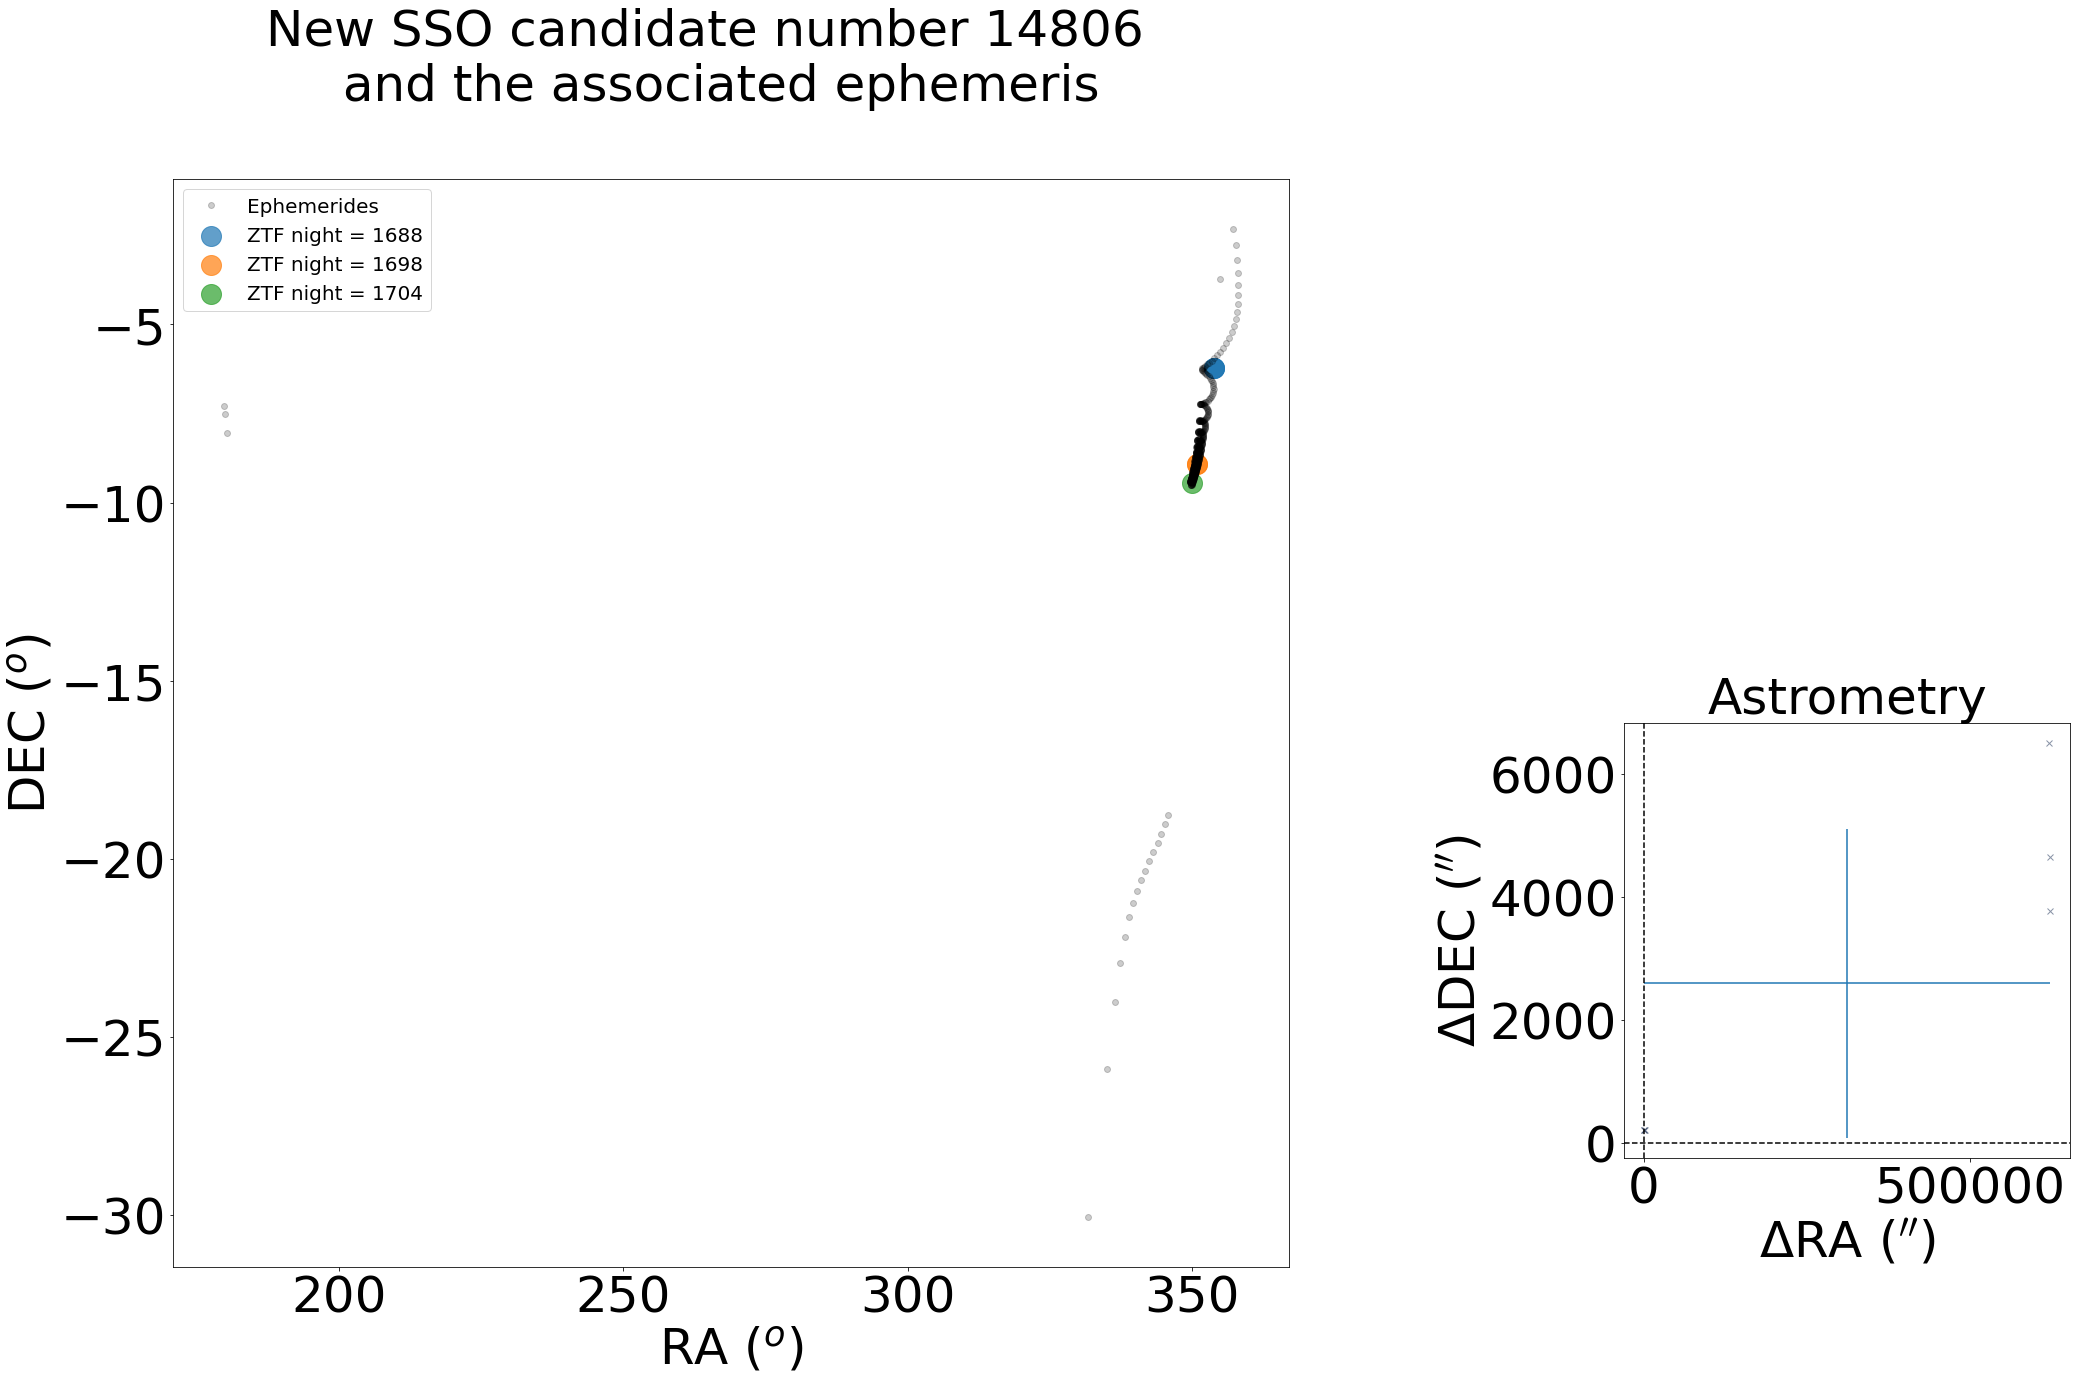

In [132]:
example_fit = fit_ephemeris(candidate_orbit, traj_orb, 14806, 500)
plot_fit_ephem(example_fit)

In [64]:
new_orb_db = df_to_orb(new_orb).table.to_pandas()

In [79]:
new_ast_score = trajectory_ephem_score(new_orb_db, new_orb.explode(["ra", "dec", "jd"]).astype({'ra': float, 'dec': float, 'jd': float}))

In [84]:
new_ast_score[["trajectory_id", "ephem_score"]].groupby("trajectory_id").agg(lambda x: list(x)[0]).sort_values("ephem_score").reset_index().iloc[:10]

trajectory_id  ephem_score
0           7686     2.117236
1           2789     3.945048
2           7462     6.141947
3           7720    20.484441
4           7777    20.931111
5           7626    22.054774
6           2916    24.017820
7           4064    25.709916
8           3763    25.870010
9           7924    26.619882